In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

# For inline plots in Jupyter
%matplotlib inline
import pandas as pd
import matplotlib as plt
import glob
import os
import xml.etree.ElementTree as ET
from datetime import datetime, timezone
from tqdm import tqdm
import codecs
import csv
#import openpyxl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Patch
    

In [2]:
data_directory_weather = "/home/paulharford/college/project/project_data/processed/WEATHERED_warnings_2014-2023_cleaned_v4.csv"
data_directory_ihfd = "/home/paulharford/college/project/project_data/processed/WEATHERED_ihfd_clean_v2.csv"
data_directory_census = "/home/paulharford/college/project/project_data/processed/WEATHERED_census_pop_age_grp_gender_region.csv"
full_path_ihfd = os.path.abspath(data_directory_ihfd)
full_path_weather = os.path.abspath(data_directory_weather)
full_path_census = os.path.abspath(data_directory_census)

In [3]:
df_ihfd = pd.read_csv(full_path_ihfd)
df_weather = pd.read_csv(full_path_weather)
df_census = pd.read_csv(full_path_census)

In [4]:
df_census.head()

,region,date,age_group,female,male,total,year
0,HSE Dublin and Midlands,2014-01-01,60 - 64,23070,23499,46569,2014
1,HSE Dublin and Midlands,2014-01-02,60 - 64,23070,23499,46569,2014
2,HSE Dublin and Midlands,2014-01-03,60 - 64,23070,23499,46569,2014
3,HSE Dublin and Midlands,2014-01-04,60 - 64,23070,23499,46569,2014
4,HSE Dublin and Midlands,2014-01-05,60 - 64,23070,23499,46569,2014


In [5]:
df_weather["Valid From"] = pd.to_datetime(df_weather["Valid From"])
df_weather["date"] = df_weather["Valid From"].dt.date
df_weather["date"] = pd.to_datetime(df_weather["date"])
df_weather["Valid To"] = pd.to_datetime(df_weather["Valid To"])


In [6]:
##add full date calandar to the aggregation 
# 1a. Identify all unique regions
regions = df_weather['region'].unique()

# 1b. Identify the full date range
min_date = df_weather['date'].min()
max_date = df_weather['date'].max()

In [7]:
##create all dates for all years to merge with datasets so we can have days with and without events 
all_dates = pd.date_range(start=min_date, end=max_date, freq='D')

multi_index = pd.MultiIndex.from_product([regions, all_dates], names=['region', 'date'])
df_region_date = pd.DataFrame(index=multi_index).reset_index()

In [8]:
df_region_date.head()

,region,date
0,HSE Dublin and Midlands,2014-01-02
1,HSE Dublin and Midlands,2014-01-03
2,HSE Dublin and Midlands,2014-01-04
3,HSE Dublin and Midlands,2014-01-05
4,HSE Dublin and Midlands,2014-01-06


In [9]:
##copy full date range for hip and weather data
df_region_date_hip = df_region_date.copy()

In [10]:
df_region_date_weather = df_region_date.copy()

In [11]:
df_region_date_census = df_region_date.copy()

In [12]:
#add column for lag
df_weather['lag_valid_to'] = df_weather['Valid To'] + pd.Timedelta(hours=12)

In [13]:
df_weather.head(10)

,Issue Time,Valid From,Valid To,Warning Colour,Warning Element,Warning Text,Clare,Cork,Kerry,Limerick,...,weather_type,Duration_hours,date,region,counties_in_region,weather_event_density,county_weight,affected_counties_count,affected_counties_proportion,lag_valid_to
0,2023-11-12 15:00:00+00:00,2023-11-13 05:00:00+00:00,2023-11-13 07:00:00+00:00,Red,Wind,Extremely gusty on Sunday night and Monday due...,0,0,0,0,...,Wind warning,2.000000,2023-11-13,HSE Dublin and Midlands,7,1,0.142857,0,0.0,2023-11-13 19:00:00+00:00
1,2023-11-12 15:00:00+00:00,2023-11-13 05:00:00+00:00,2023-11-13 07:00:00+00:00,Red,Wind,Extremely gusty on Sunday night and Monday due...,0,0,0,0,...,Wind warning,2.000000,2023-11-13,HSE Dublin and South East,7,1,0.142857,0,0.0,2023-11-13 19:00:00+00:00
2,2023-11-12 15:00:00+00:00,2023-11-13 05:00:00+00:00,2023-11-13 07:00:00+00:00,Red,Wind,Extremely gusty on Sunday night and Monday due...,0,0,0,0,...,Wind warning,2.000000,2023-11-13,HSE Mid West,3,1,0.333333,0,0.0,2023-11-13 19:00:00+00:00
3,2023-11-12 15:00:00+00:00,2023-11-13 05:00:00+00:00,2023-11-13 07:00:00+00:00,Red,Wind,Extremely gusty on Sunday night and Monday due...,0,0,0,0,...,Wind warning,2.000000,2023-11-13,HSE South West,2,1,0.500000,0,0.0,2023-11-13 19:00:00+00:00
4,2023-11-12 15:00:00+00:00,2023-11-13 05:00:00+00:00,2023-11-13 07:00:00+00:00,Red,Wind,Extremely gusty on Sunday night and Monday due...,0,0,0,0,...,Wind warning,2.000000,2023-11-13,HSE West and North West,6,1,0.166667,0,0.0,2023-11-13 19:00:00+00:00
5,2023-11-12 15:00:00+00:00,2023-11-13 03:00:00+00:00,2023-11-13 05:00:00+00:00,Red,Wind,Extremely gusty on Sunday night and early Mond...,0,0,0,0,...,Wind warning,2.000000,2023-11-13,HSE Dublin and North East,5,1,0.200000,0,0.0,2023-11-13 17:00:00+00:00
6,2021-12-07 12:05:59+00:00,2021-12-07 12:05:39+00:00,2021-12-07 21:00:00+00:00,Red,Red Wind,Storm Barra: Southwesterly winds later veering...,0,1,1,0,...,Wind warning,8.905833,2021-12-07,HSE South West,2,1,0.500000,2,1.0,2021-12-08 09:00:00+00:00
7,2017-10-16 16:02:38+00:00,2017-10-16 16:00:00+00:00,2017-10-17 01:00:00+00:00,Red,Wind,"Latest UpdateStorm Ophelia (Ex hurricane), sit...",1,1,1,1,...,Wind warning,9.000000,2017-10-16,HSE West and North West,6,1,0.166667,6,1.0,2017-10-17 13:00:00+00:00
8,2015-01-14 14:00:00+00:00,2015-01-14 21:00:00+00:00,2015-01-15 12:00:00+00:00,Red,Wind,Wind gusts 130 to 150km/h possible.High onshor...,1,0,1,1,...,Wind warning,15.000000,2015-01-14,HSE South West,2,1,0.500000,1,0.5,2015-01-16 00:00:00+00:00
9,2015-01-14 14:00:00+00:00,2015-01-14 21:00:00+00:00,2015-01-15 12:00:00+00:00,Red,Wind,Wind gusts 130 to 150km/h possible.High onshor...,1,0,1,1,...,Wind warning,15.000000,2015-01-14,HSE West and North West,6,1,0.166667,3,0.5,2015-01-16 00:00:00+00:00


In [14]:
severity_mapping = {
    'Yellow': 1,
    'Orange': 2,
    'Red': 3
}

df_weather['warning_severity_numeric'] = df_weather['warning_severity'].map(severity_mapping)

In [15]:
def aggregate_weather_data(df_weather, keep_columns=None):
    """
    Aggregate weather data by region, date, weather_type, and warning_severity while
    preserving specified additional columns.
    
    Args:
        df_weather: DataFrame containing weather data
        keep_columns: List of additional columns to preserve (beyond the groupby columns)
        
    Returns:
        Aggregated DataFrame with one row per unique region-date-weather_type-warning_severity combination
    """
    # Define default columns to keep if none provided
    if keep_columns is None:
        keep_columns = [
            'counties_in_region', 	
            'county_weight'	
         ]
    
    # Define all columns to group by
    group_cols = ['region', 'date', 'warning_phenomenon', 'warning_severity']
    
    # Define aggregation functions for numeric and other columns
    agg_dict = {
        'warning_severity_numeric': 'max'
    }
    
    # Add aggregation functions for additional columns to preserve
    for col in keep_columns:
        if col in df_weather.columns:
            # For string columns, take the first value (assuming they're the same within groups)
            if df_weather[col].dtype == 'object':
                agg_dict[col] = 'first'
            # For boolean or integer flags (like has_multiple_events, warning_upgraded)
            elif df_weather[col].dtype in ['bool', 'int64', 'int32']:
                agg_dict[col] = 'max'
            # For numeric columns, take the max
            elif pd.api.types.is_numeric_dtype(df_weather[col]):
                agg_dict[col] = 'max'
            # For datetime columns
            elif pd.api.types.is_datetime64_dtype(df_weather[col]):
                agg_dict[col] = 'max'
            # Default to first value for any other types
            else:
                agg_dict[col] = 'first'
    
    # Group by the specified columns and aggregate
    weather_agg = df_weather.groupby(group_cols, as_index=False).agg(agg_dict)
    
    # Add the weather flag column (set to 1 if there is any event)
    weather_agg['weather_event'] = 1
    
    return weather_agg

In [16]:
weather_agg = aggregate_weather_data(df_weather)

In [17]:
weather_agg.head()

,region,date,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,county_weight,weather_event
0,HSE Dublin and Midlands,2014-01-02,Wind,Yellow,1,7,0.142857,1
1,HSE Dublin and Midlands,2014-01-03,Wind,Yellow,1,7,0.142857,1
2,HSE Dublin and Midlands,2014-01-04,Snow_Ice,Yellow,1,7,0.142857,1
3,HSE Dublin and Midlands,2014-01-05,Wind,Yellow,1,7,0.142857,1
4,HSE Dublin and Midlands,2014-01-06,Wind,Orange,2,7,0.142857,1


In [18]:
df_weather_final = pd.merge(
    df_region_date_weather,          # all region-date combos
    weather_agg,               # your aggregated counts
    on=['region', 'date'],   # merge keys
    how='left'               # left-join so we keep all rows from df_region_date
)


In [19]:
df_weather_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22511 entries, 0 to 22510
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   region                    22511 non-null  object        
 1   date                      22511 non-null  datetime64[ns]
 2   warning_phenomenon        4571 non-null   object        
 3   warning_severity          4571 non-null   object        
 4   warning_severity_numeric  4571 non-null   float64       
 5   counties_in_region        4571 non-null   float64       
 6   county_weight             4571 non-null   float64       
 7   weather_event             4571 non-null   float64       
dtypes: datetime64[ns](1), float64(4), object(3)
memory usage: 1.4+ MB


In [20]:
##after joing wetaher data to full fate range there and NaN values, whixh is expected as not all days have weather events
df_weather_final['warning_severity_numeric'] = df_weather_final['warning_severity_numeric'].fillna(0)

In [21]:
df_weather_final['weather_event'] = df_weather_final['weather_event'].fillna(0)

In [22]:
df_weather_final['warning_phenomenon'] = df_weather_final['warning_phenomenon'].fillna('no_weather_type')

In [23]:
df_weather_final['warning_severity'] = df_weather_final['warning_severity'].fillna('no_severity')

In [24]:
## So the final weather warning_phenomenon has per region the severity, if there was a wether event or not, the numer of counties the evnet was in and the weather tyep (wind/rain etc)
df_weather_final.head(10)

,region,date,warning_phenomenon,warning_severity,warning_severity_numeric,counties_in_region,county_weight,weather_event
0,HSE Dublin and Midlands,2014-01-02,Wind,Yellow,1.0,7.0,0.142857,1.0
1,HSE Dublin and Midlands,2014-01-03,Wind,Yellow,1.0,7.0,0.142857,1.0
2,HSE Dublin and Midlands,2014-01-04,Snow_Ice,Yellow,1.0,7.0,0.142857,1.0
3,HSE Dublin and Midlands,2014-01-05,Wind,Yellow,1.0,7.0,0.142857,1.0
4,HSE Dublin and Midlands,2014-01-06,Wind,Orange,2.0,7.0,0.142857,1.0
5,HSE Dublin and Midlands,2014-01-07,no_weather_type,no_severity,0.0,NaN,NaN,0.0
6,HSE Dublin and Midlands,2014-01-08,no_weather_type,no_severity,0.0,NaN,NaN,0.0
7,HSE Dublin and Midlands,2014-01-09,no_weather_type,no_severity,0.0,NaN,NaN,0.0
8,HSE Dublin and Midlands,2014-01-10,no_weather_type,no_severity,0.0,NaN,NaN,0.0
9,HSE Dublin and Midlands,2014-01-11,no_weather_type,no_severity,0.0,NaN,NaN,0.0


## Hip Data
#### get hip data ready to merge with weather data

In [25]:
df_ihfd["Adm_First_Pres_Hosp_DateTime"] = pd.to_datetime(df_ihfd["Adm_First_Pres_Hosp_DateTime"])
df_ihfd["date"] = df_ihfd["Adm_First_Pres_Hosp_DateTime"].dt.date
# convert to a pandas datetime if you prefer consistency
df_ihfd["date"] = pd.to_datetime(df_ihfd["date"])

In [26]:
df_ihfd.head()

,region,NOCA_TraumaPeriodDay,Adm_First_Pres_Hosp_DateTime,NOCA_FirstPresPeriodDay,age_group,gender,LOS,Adm_Trauma_TYPE,Adm_Ward_Type,Adm_Pre_Frac_Indoor,...,Adm_Asa_Grade,Adm_Anaesthesia,Adm_Surgery_Delay_Reason,Adm_Mobilised,Adm_Pressure_Ulcers,Adm_Spec_Falls_Assess,Adm_Bone_Protect_Med,Adm_Multi_Rehab_Assess,date,year
0,HSE Mid West,AM,2016-09-06,PM,70-74,Female,12,2.0,1.0,2.0,...,3.0,5.0,7.0,1.0,2.0,1.0,1.0,1.0,2016-09-06,2016
1,HSE Mid West,AM,2016-09-15,Night,85 years and over,Female,4,2.0,1.0,2.0,...,2.0,5.0,0.0,1.0,2.0,1.0,1.0,1.0,2016-09-15,2016
2,HSE Mid West,AM,2016-09-14,AM,75-79,Male,6,2.0,1.0,2.0,...,2.0,5.0,0.0,1.0,2.0,1.0,5.0,1.0,2016-09-14,2016
3,HSE Mid West,AM,2016-09-04,AM,85 years and over,Female,16,2.0,1.0,2.0,...,3.0,5.0,0.0,1.0,2.0,1.0,1.0,1.0,2016-09-04,2016
4,HSE Mid West,AM,2016-08-23,Night,65-69,Male,29,2.0,1.0,2.0,...,3.0,5.0,2.0,1.0,2.0,1.0,1.0,1.0,2016-08-23,2016


In [27]:
df_ihfd_filtered = df_ihfd[
    (df_ihfd['date'] >= '2014-01-01') & 
    (df_ihfd['date'] <= '2023-12-31').copy()
]

def month_to_season(month):
    # Convert month to an integer if it isn't already.
    month = int(month)
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'unknown'

df_ihfd_season = df_ihfd_filtered.copy()
df_ihfd_season['month'] = df_ihfd_season['date'].dt.month
df_weather_full['month'] = df_weather_full['date'].dt.month
df_weather_full['season'] = df_weather_full['month'].apply(month_to_season)
df_ihfd_season['season'] = df_ihfd_season['month'].apply(month_to_season)


In [28]:
nan_counts = df_ihfd_filtered.isna().sum()
print(nan_counts)

region                          0
NOCA_TraumaPeriodDay            0
Adm_First_Pres_Hosp_DateTime    0
NOCA_FirstPresPeriodDay         0
age_group                       0
gender                          0
LOS                             0
Adm_Trauma_TYPE                 0
Adm_Ward_Type                   0
Adm_Pre_Frac_Indoor             0
Adm_PRE_Frac_Outdoor            0
Adm_Pre_Frac_Shop               0
Adm_Pre_Frac_Number             0
Adm_Fracture_Type               0
Adm_Pathological                0
Adm_Fragility                   0
Adm_Pre_OP_Med_Assess           0
Adm_Ger_Acute_Assess            0
Adm_Operation                   0
Adm_Asa_Grade                   0
Adm_Anaesthesia                 0
Adm_Surgery_Delay_Reason        0
Adm_Mobilised                   0
Adm_Pressure_Ulcers             0
Adm_Spec_Falls_Assess           0
Adm_Bone_Protect_Med            0
Adm_Multi_Rehab_Assess          0
date                            0
year                            0
dtype: int64


## merging

In [29]:
hip_agg = (
    df_ihfd_filtered
    .groupby(['region', 'date', 'age_group', 'gender'])
    .agg(
        hip_fracture_count=('date', 'count'),
        LOS=('LOS', 'max')
    )
    .reset_index()
)


In [30]:
hip_agg.head()


,region,date,age_group,gender,hip_fracture_count,LOS
0,HSE Dublin and Midlands,2014-01-02,65-69,Female,1,8
1,HSE Dublin and Midlands,2014-01-04,65-69,Female,1,11
2,HSE Dublin and Midlands,2014-01-04,80-84,Female,1,19
3,HSE Dublin and Midlands,2014-01-04,85 years and over,Female,2,61
4,HSE Dublin and Midlands,2014-01-06,65-69,Male,1,7


In [31]:
df_hip_final = pd.merge(
    df_region_date_hip,          # all region-date combos
    hip_agg,               # your aggregated counts
    on=['region', 'date'],   # merge keys
    how='left'               # left-join so we keep all rows from df_region_date
)

In [32]:
df_hip_final.head(15)

,region,date,age_group,gender,hip_fracture_count,LOS
0,HSE Dublin and Midlands,2014-01-02,65-69,Female,1.0,8.0
1,HSE Dublin and Midlands,2014-01-03,NaN,NaN,NaN,NaN
2,HSE Dublin and Midlands,2014-01-04,65-69,Female,1.0,11.0
3,HSE Dublin and Midlands,2014-01-04,80-84,Female,1.0,19.0
4,HSE Dublin and Midlands,2014-01-04,85 years and over,Female,2.0,61.0
5,HSE Dublin and Midlands,2014-01-05,NaN,NaN,NaN,NaN
6,HSE Dublin and Midlands,2014-01-06,65-69,Male,1.0,7.0
7,HSE Dublin and Midlands,2014-01-07,NaN,NaN,NaN,NaN
8,HSE Dublin and Midlands,2014-01-08,75-79,Female,1.0,9.0
9,HSE Dublin and Midlands,2014-01-09,85 years and over,Female,1.0,76.0


In [33]:
df_hip_final['hip_fracture_count'] = df_hip_final['hip_fracture_count'].fillna(0)

In [34]:
df_hip_final['LOS'] = df_hip_final['LOS'].fillna(0)

In [35]:
df_hip_final['age_group'] = df_hip_final['age_group'].fillna('no_hip_fractures')

In [36]:
df_hip_final['gender'] = df_hip_final['gender'].fillna('no_hip_fractures')

In [37]:
df_hip_final.head(15)

,region,date,age_group,gender,hip_fracture_count,LOS
0,HSE Dublin and Midlands,2014-01-02,65-69,Female,1.0,8.0
1,HSE Dublin and Midlands,2014-01-03,no_hip_fractures,no_hip_fractures,0.0,0.0
2,HSE Dublin and Midlands,2014-01-04,65-69,Female,1.0,11.0
3,HSE Dublin and Midlands,2014-01-04,80-84,Female,1.0,19.0
4,HSE Dublin and Midlands,2014-01-04,85 years and over,Female,2.0,61.0
5,HSE Dublin and Midlands,2014-01-05,no_hip_fractures,no_hip_fractures,0.0,0.0
6,HSE Dublin and Midlands,2014-01-06,65-69,Male,1.0,7.0
7,HSE Dublin and Midlands,2014-01-07,no_hip_fractures,no_hip_fractures,0.0,0.0
8,HSE Dublin and Midlands,2014-01-08,75-79,Female,1.0,9.0
9,HSE Dublin and Midlands,2014-01-09,85 years and over,Female,1.0,76.0


In [38]:
# Merge hip and weather data
df_hip_weather = df_hip_final.merge(
    df_weather_final[['region', 'date', 'weather_event','warning_phenomenon', 'warning_severity', 
                'warning_severity_numeric']],
    on=['region', 'date'],
    how='left'
)


In [39]:
df_hip_weather.head(10)

,region,date,age_group,gender,hip_fracture_count,LOS,weather_event,warning_phenomenon,warning_severity,warning_severity_numeric
0,HSE Dublin and Midlands,2014-01-02,65-69,Female,1.0,8.0,1.0,Wind,Yellow,1.0
1,HSE Dublin and Midlands,2014-01-03,no_hip_fractures,no_hip_fractures,0.0,0.0,1.0,Wind,Yellow,1.0
2,HSE Dublin and Midlands,2014-01-04,65-69,Female,1.0,11.0,1.0,Snow_Ice,Yellow,1.0
3,HSE Dublin and Midlands,2014-01-04,80-84,Female,1.0,19.0,1.0,Snow_Ice,Yellow,1.0
4,HSE Dublin and Midlands,2014-01-04,85 years and over,Female,2.0,61.0,1.0,Snow_Ice,Yellow,1.0
5,HSE Dublin and Midlands,2014-01-05,no_hip_fractures,no_hip_fractures,0.0,0.0,1.0,Wind,Yellow,1.0
6,HSE Dublin and Midlands,2014-01-06,65-69,Male,1.0,7.0,1.0,Wind,Orange,2.0
7,HSE Dublin and Midlands,2014-01-07,no_hip_fractures,no_hip_fractures,0.0,0.0,0.0,no_weather_type,no_severity,0.0
8,HSE Dublin and Midlands,2014-01-08,75-79,Female,1.0,9.0,0.0,no_weather_type,no_severity,0.0
9,HSE Dublin and Midlands,2014-01-09,85 years and over,Female,1.0,76.0,0.0,no_weather_type,no_severity,0.0


In [40]:
df_hip_weather['warning_severity'] = df_hip_weather['warning_severity'].fillna('no_warning_severity')

In [41]:
df_hip_weather['warning_phenomenon'] = df_hip_weather['warning_phenomenon'].fillna('no_weather_type')

In [42]:
df_hip_weather['warning_severity_numeric'] = df_hip_weather['warning_severity_numeric'].fillna(0)

In [43]:
df_hip_weather['weather_event'] = df_hip_weather['weather_event'].fillna(0)

In [44]:
df_hip_weather.isna().sum()


region                      0
date                        0
age_group                   0
gender                      0
hip_fracture_count          0
LOS                         0
weather_event               0
warning_phenomenon          0
warning_severity            0
warning_severity_numeric    0
dtype: int64

In [45]:
df_census.head(10)

,region,date,age_group,female,male,total,year
0,HSE Dublin and Midlands,2014-01-01,60 - 64,23070,23499,46569,2014
1,HSE Dublin and Midlands,2014-01-02,60 - 64,23070,23499,46569,2014
2,HSE Dublin and Midlands,2014-01-03,60 - 64,23070,23499,46569,2014
3,HSE Dublin and Midlands,2014-01-04,60 - 64,23070,23499,46569,2014
4,HSE Dublin and Midlands,2014-01-05,60 - 64,23070,23499,46569,2014
5,HSE Dublin and Midlands,2014-01-06,60 - 64,23070,23499,46569,2014
6,HSE Dublin and Midlands,2014-01-07,60 - 64,23070,23499,46569,2014
7,HSE Dublin and Midlands,2014-01-08,60 - 64,23070,23499,46569,2014
8,HSE Dublin and Midlands,2014-01-09,60 - 64,23070,23499,46569,2014
9,HSE Dublin and Midlands,2014-01-10,60 - 64,23070,23499,46569,2014


In [46]:
print(sorted(df_census['age_group'].unique()))

['60 - 64', '65 - 69', '70 - 74', '75 - 79', '80 - 84', '85 and over']


In [47]:
print(sorted(df_hip_weather['age_group'].unique()))

['60-64', '65-69', '70-74', '75-79', '80-84', '85 years and over', 'no_hip_fractures']


In [48]:
df_hip_weather['date'] = pd.to_datetime(df_hip_weather['date'])
df_census['date'] = pd.to_datetime(df_census['date'])

In [49]:
df_census.head()

,region,date,age_group,female,male,total,year
0,HSE Dublin and Midlands,2014-01-01,60 - 64,23070,23499,46569,2014
1,HSE Dublin and Midlands,2014-01-02,60 - 64,23070,23499,46569,2014
2,HSE Dublin and Midlands,2014-01-03,60 - 64,23070,23499,46569,2014
3,HSE Dublin and Midlands,2014-01-04,60 - 64,23070,23499,46569,2014
4,HSE Dublin and Midlands,2014-01-05,60 - 64,23070,23499,46569,2014


In [50]:
print(sorted(df_census['age_group'].unique()))

['60 - 64', '65 - 69', '70 - 74', '75 - 79', '80 - 84', '85 and over']


In [51]:
# Create a mapping dictionary to convert census age groups to match hip weather format
# Note: This maps FROM census format TO hip_weather format
age_group_mapping = {
    '60 - 64': '60-64',
    '65 - 69': '65-69',
    '70 - 74': '70-74',
    '75 - 79': '75-79',
    '80 - 84': '80-84',
    '85 and over': '85 years and over'
}

# Apply the mapping directly to the age_group column in df_census
df_census['age_group'] = df_census['age_group'].map(age_group_mapping)

# Verify the mapping worked correctly
print("Census age groups after mapping:")
for age in sorted(df_census['age_group'].unique()):
    print(f"  '{age}'")

# Ensure dates are in the same format
df_hip_weather['date'] = pd.to_datetime(df_hip_weather['date']).dt.date
df_census['date'] = pd.to_datetime(df_census['date']).dt.date

# Perform the merge using the modified age_group column
df_final = df_hip_weather.merge(
    df_census[['region', 'date', 'age_group', 'female', 'male', 'total']],
    on=['region', 'date', 'age_group'],
    how='left'
)

# Add the population column based on gender
df_final['population'] = df_final.apply(
    lambda row: row['female'] if row['gender'] == 'Female' else
                row['male'] if row['gender'] == 'Male' else
                row['total'],
    axis=1
)

# Check results
print(f"\nTotal rows in final dataset: {len(df_final)}")
print(f"Rows with population data: {df_final['population'].notna().sum()}")
print(df_final[['region', 'date', 'age_group', 'gender', 'female', 'male', 'total', 'population']].head())

Census age groups after mapping:
  '60-64'
  '65-69'
  '70-74'
  '75-79'
  '80-84'
  '85 years and over'

Total rows in final dataset: 37004
Rows with population data: 31539
                    region        date          age_group            gender  \
0  HSE Dublin and Midlands  2014-01-02              65-69            Female   
1  HSE Dublin and Midlands  2014-01-03   no_hip_fractures  no_hip_fractures   
2  HSE Dublin and Midlands  2014-01-04              65-69            Female   
3  HSE Dublin and Midlands  2014-01-04              80-84            Female   
4  HSE Dublin and Midlands  2014-01-04  85 years and over            Female   

    female     male    total  population  
0  19327.0  20035.0  39362.0     19327.0  
1      NaN      NaN      NaN         NaN  
2  19327.0  20035.0  39362.0     19327.0  
3   8096.0   6635.0  14731.0      8096.0  
4   7694.0   5328.0  13022.0      7694.0  


In [52]:
df_final.isnull().sum()

region                         0
date                           0
age_group                      0
gender                         0
hip_fracture_count             0
LOS                            0
weather_event                  0
warning_phenomenon             0
warning_severity               0
warning_severity_numeric       0
female                      5465
male                        5465
total                       5465
population                  5465
dtype: int64

In [53]:
# Step 1: Identify the rows with "no_hip_fractures"
no_fracture_rows = df_final[df_final['gender'] == 'no_hip_fractures'].copy()

# Step 2: Remove these rows from the original dataframe
df_final_cleaned = df_final[df_final['gender'] != 'no_hip_fractures'].copy()

# Step 3: Calculate the proportion of population by gender and age group within each region
population_props = df_final_cleaned.groupby(['region', 'gender', 'age_group'])['population'].mean().reset_index()
total_by_region = population_props.groupby('region')['population'].sum().reset_index()
population_props = population_props.merge(total_by_region, on='region', suffixes=('', '_total'))
population_props['proportion'] = population_props['population'] / population_props['population_total']

# Step 4: Create a list to store new rows
new_rows = []

# Step 5: For each "no_fracture" row, create corresponding rows for each demographic group
for _, row in no_fracture_rows.iterrows():
    region = row['region']
    date = row['date']
    weather_event = row['weather_event']
    warning_phenomenon = row['warning_phenomenon']
    warning_severity = row['warning_severity']
    warning_severity_numeric = row['warning_severity_numeric']
    
    # Get demographic breakdowns for this region
    region_demographics = population_props[population_props['region'] == region]
    
    # Create a new row for each demographic group in this region
    for _, demo_row in region_demographics.iterrows():
        gender = demo_row['gender']
        age_group = demo_row['age_group']
        population = demo_row['population']
        
        # Create new row with appropriate demographics but zero fractures
        new_row = row.copy()
        new_row['gender'] = gender
        new_row['age_group'] = age_group
        new_row['hip_fracture_count'] = 0
        new_row['population'] = population
        new_row['log_population'] = np.log(population) if population > 0 else np.nan
        
        # Add additional columns as needed
        if 'female' in df_final.columns:
            new_row['female'] = population if gender == 'Female' else 0
        if 'male' in df_final.columns:
            new_row['male'] = population if gender == 'Male' else 0
        if 'total' in df_final.columns:
            new_row['total'] = population
            
        # Add the new row to our list
        new_rows.append(new_row)

# Step 6: Convert the list of new rows to a DataFrame
expanded_rows = pd.DataFrame(new_rows)

# Step 7: Combine with the cleaned DataFrame
df_final_expanded = pd.concat([df_final_cleaned, expanded_rows], ignore_index=True)

# Step 8: Sort by region, date, gender, age_group for clarity
df_final_expanded = df_final_expanded.sort_values(['region', 'date', 'gender', 'age_group'])

# Step 9: Check the results
print(f"Original dataframe shape: {df_final.shape}")
print(f"Expanded dataframe shape: {df_final_expanded.shape}")
print(f"Number of no_hip_fractures rows: {len(no_fracture_rows)}")

Original dataframe shape: (37004, 14)
Expanded dataframe shape: (97119, 15)
Number of no_hip_fractures rows: 5465


In [54]:
df_final_expanded.isnull().sum()

region                          0
date                            0
age_group                       0
gender                          0
hip_fracture_count              0
LOS                             0
weather_event                   0
warning_phenomenon              0
warning_severity                0
warning_severity_numeric        0
female                          0
male                            0
total                           0
population                      0
log_population              31539
dtype: int64

In [55]:
df_final_expanded['log_population'] = np.log(df_final_expanded['population'])

## Additional variables Season and lag to help improve model 

In [56]:
# Add month number
df_final_expanded['month'] = pd.DatetimeIndex(df_final_expanded['date']).month

# Create seasons (meteorological seasons)
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:  # months 9, 10, 11
        return 'Autumn'

df_final_expanded['season'] = df_final_expanded['month'].apply(assign_season)

# Create dummy variables for seasons
df_final_expanded['is_winter'] = (df_final_expanded['season'] == 'Winter').astype(int)
df_final_expanded['is_spring'] = (df_final_expanded['season'] == 'Spring').astype(int)
df_final_expanded['is_summer'] = (df_final_expanded['season'] == 'Summer').astype(int)
df_final_expanded['is_autumn'] = (df_final_expanded['season'] == 'Autumn').astype(int)

In [57]:
# Sort by region and date
df_final_expanded = df_final_expanded.sort_values(['region', 'date'])

# Create lagged variables based on warning severity
# First, create indicator for orange warnings
df_final_expanded['orange_warning'] = ((df_final_expanded['warning_severity'] == 'Orange') | 
                             (df_final_expanded['warning_severity_numeric'] == 2)).astype(int)

# Create indicator for red warnings
df_final_expanded['red_warning'] = ((df_final_expanded['warning_severity'] == 'Red') | 
                           (df_final_expanded['warning_severity_numeric'] == 3)).astype(int)

# Within each region, create lagged variables
df_final_expanded['orange_warning_lag'] = df_final_expanded.groupby('region')['orange_warning'].shift(1)
df_final_expanded['red_warning_lag'] = df_final_expanded.groupby('region')['red_warning'].shift(1)

In [58]:
# Create broader weather categories
df_final_expanded['cold_weather'] = df_final_expanded['warning_phenomenon'].isin(
    ['Snow_Ice', 'Ice', 'Low-Temperature', 'Low-Temperature_Ice', 'Fog']).astype(int)

df_final_expanded['wind_weather'] = df_final_expanded['warning_phenomenon'].isin(['Wind']).astype(int)

df_final_expanded['precipitation'] = df_final_expanded['warning_phenomenon'].isin(
    ['Rainfall', 'Thunder', 'Hail']).astype(int)

df_final_expanded['heat_weather'] = df_final_expanded['warning_phenomenon'].isin(['High-Temperature']).astype(int)

df_final_expanded['no_adverse_weather'] = df_final_expanded['warning_phenomenon'].isin(
    ['no_weather_type']).astype(int)


# Create lagged variables for each type
df_final_expanded['cold_lag'] = df_final_expanded.groupby('region')['cold_weather'].shift(1)
df_final_expanded['wind_lag'] = df_final_expanded.groupby('region')['wind_weather'].shift(1)
df_final_expanded['precip_lag'] = df_final_expanded.groupby('region')['precipitation'].shift(1)
df_final_expanded['heat_lag'] = df_final_expanded.groupby('region')['heat_weather'].shift(1)

In [59]:
# Check for NaN values in new columns
nan_counts = {
    'cold_weather': df_final_expanded['cold_weather'].isna().sum(),
    'wind_weather': df_final_expanded['wind_weather'].isna().sum(),
    'precipitation': df_final_expanded['precipitation'].isna().sum(),
    'heat_weather': df_final_expanded['heat_weather'].isna().sum(),
    'cold_lag': df_final_expanded['cold_lag'].isna().sum(),
    'wind_lag': df_final_expanded['wind_lag'].isna().sum(),
    'precip_lag': df_final_expanded['precip_lag'].isna().sum(),
    'heat_lag': df_final_expanded['heat_lag'].isna().sum(),
    'is_winter': df_final_expanded['is_winter'].isna().sum(),
    'is_spring': df_final_expanded['is_spring'].isna().sum(),
    'is_summer': df_final_expanded['is_summer'].isna().sum(),
    'is_autumn': df_final_expanded['is_autumn'].isna().sum(),
    'orange_warning_lag': df_final_expanded['orange_warning_lag'].isna().sum(),
    'red_warning_lag': df_final_expanded['red_warning_lag'].isna().sum()
}

print("NaN counts in new features:")
for feature, count in nan_counts.items():
    print(f"{feature}: {count}")


NaN counts in new features:
cold_weather: 0
wind_weather: 0
precipitation: 0
heat_weather: 0
cold_lag: 6
wind_lag: 6
precip_lag: 6
heat_lag: 6
is_winter: 0
is_spring: 0
is_summer: 0
is_autumn: 0
orange_warning_lag: 6
red_warning_lag: 6


In [60]:
# Fill NaN values with 0 for lag variables
lag_columns = ['cold_lag', 'wind_lag', 'precip_lag', 'heat_lag', 'orange_warning_lag', 'red_warning_lag']
df_final_expanded[lag_columns] = df_final_expanded[lag_columns].fillna(0)

In [61]:
df_final_expanded.head(15)

,region,date,age_group,gender,hip_fracture_count,LOS,weather_event,warning_phenomenon,warning_severity,warning_severity_numeric,...,red_warning_lag,cold_weather,wind_weather,precipitation,heat_weather,no_adverse_weather,cold_lag,wind_lag,precip_lag,heat_lag
0,HSE Dublin and Midlands,2014-01-02,65-69,Female,1.0,8.0,1.0,Wind,Yellow,1.0,...,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0
31539,HSE Dublin and Midlands,2014-01-03,60-64,Female,0.0,0.0,1.0,Wind,Yellow,1.0,...,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0
31540,HSE Dublin and Midlands,2014-01-03,65-69,Female,0.0,0.0,1.0,Wind,Yellow,1.0,...,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0
31541,HSE Dublin and Midlands,2014-01-03,70-74,Female,0.0,0.0,1.0,Wind,Yellow,1.0,...,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0
31542,HSE Dublin and Midlands,2014-01-03,75-79,Female,0.0,0.0,1.0,Wind,Yellow,1.0,...,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0
31543,HSE Dublin and Midlands,2014-01-03,80-84,Female,0.0,0.0,1.0,Wind,Yellow,1.0,...,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0
31544,HSE Dublin and Midlands,2014-01-03,85 years and over,Female,0.0,0.0,1.0,Wind,Yellow,1.0,...,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0
31545,HSE Dublin and Midlands,2014-01-03,60-64,Male,0.0,0.0,1.0,Wind,Yellow,1.0,...,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0
31546,HSE Dublin and Midlands,2014-01-03,65-69,Male,0.0,0.0,1.0,Wind,Yellow,1.0,...,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0
31547,HSE Dublin and Midlands,2014-01-03,70-74,Male,0.0,0.0,1.0,Wind,Yellow,1.0,...,0.0,0,1,0,0,0,0.0,1.0,0.0,0.0


## Search for most correlating features using seaborn and sweetviz

Correlations with hip_fracture_count:
hip_fracture_count          1.000000
LOS                         0.526502
total                       0.453265
female                      0.344067
male                        0.241170
is_winter                   0.039470
cold_weather                0.031975
cold_lag                    0.031811
orange_warning              0.020927
orange_warning_lag          0.018827
warning_severity_numeric    0.014164
weather_event               0.013177
heat_weather                0.000602
wind_lag                   -0.000659
wind_weather               -0.001639
heat_lag                   -0.001804
log_population             -0.002251
precip_lag                 -0.003663
is_spring                  -0.004264
precipitation              -0.005347
month                      -0.008808
is_autumn                  -0.009603
red_warning_lag            -0.010515
no_adverse_weather         -0.013177
red_warning                -0.013222
is_summer                  -0.025028


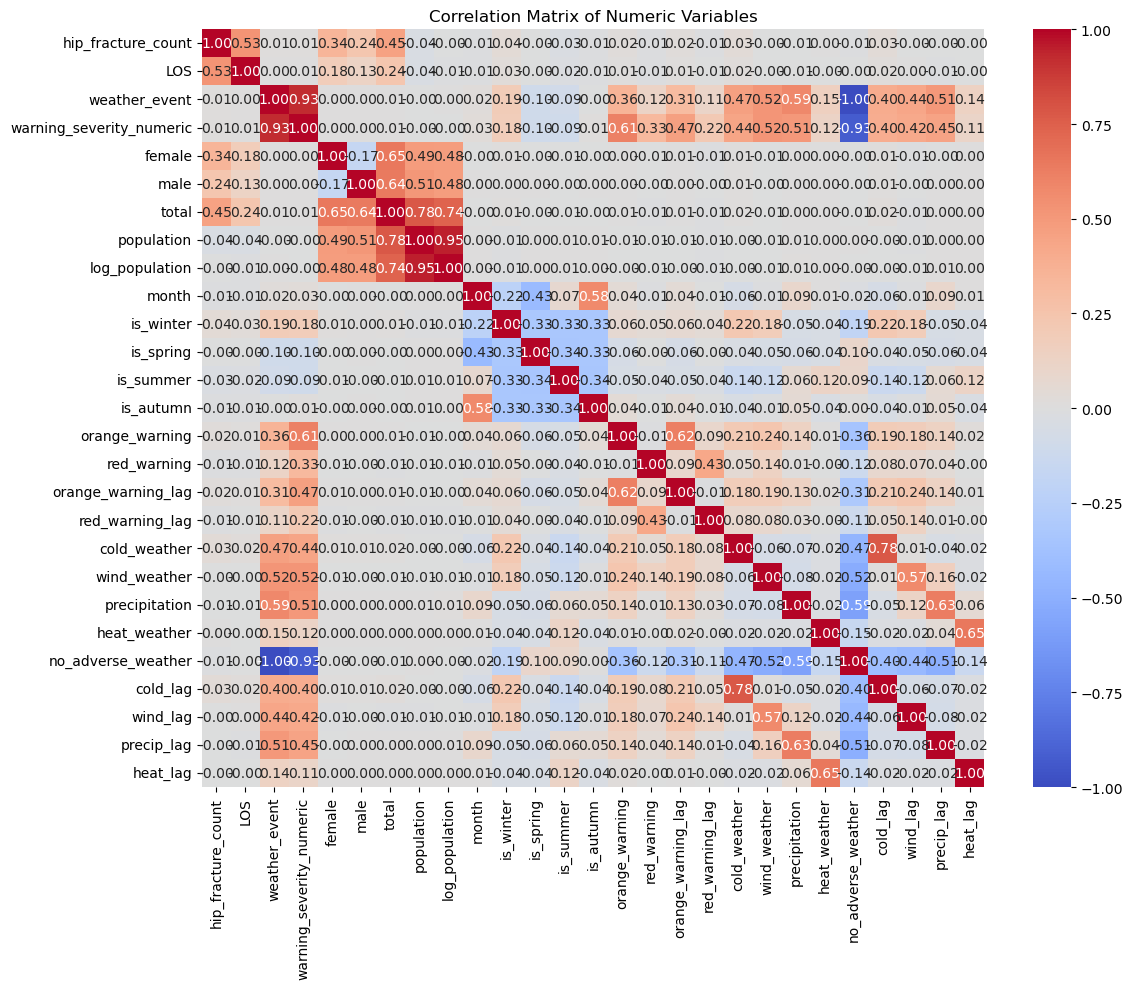

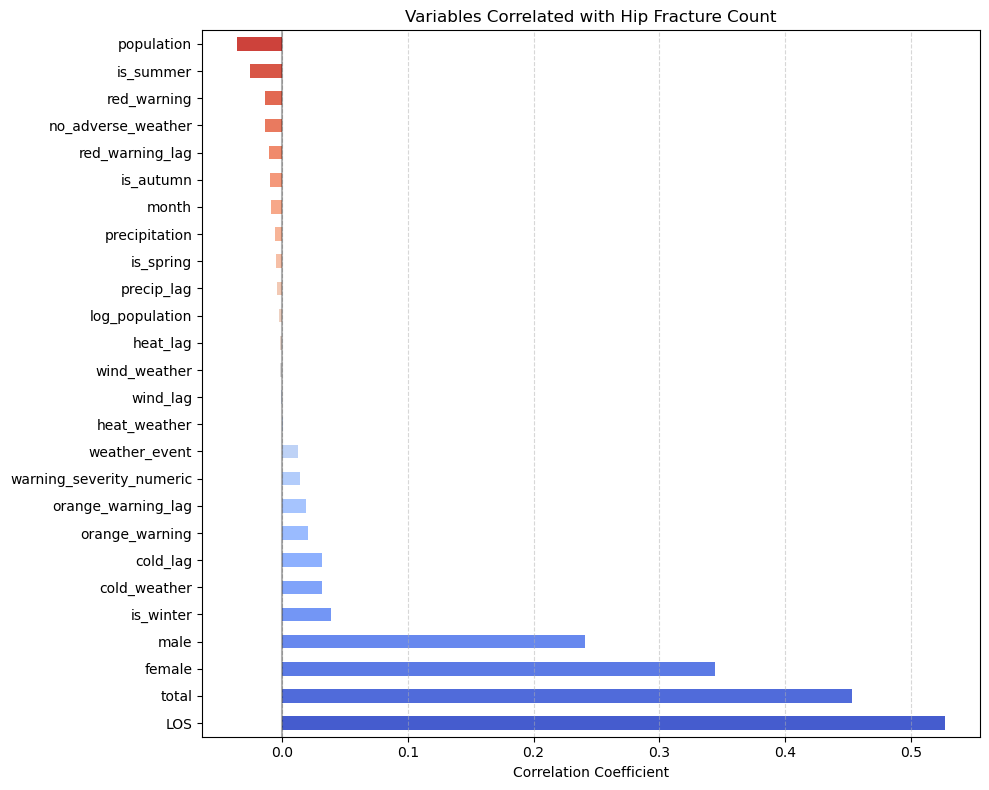

In [62]:
import matplotlib.pyplot as plt 
numeric_cols = df_final_expanded.select_dtypes(include=[np.number]).columns.tolist()

# Make sure 'hip_fracture_count' is included
if 'hip_fracture_count' not in numeric_cols:
    print("Warning: hip_fracture_count not found in numeric columns")
else:
    # Create a correlation matrix
    corr_matrix = df_final_expanded[numeric_cols].corr(method='pearson')
    
    # Sort correlations with hip_fracture_count
    hip_correlations = corr_matrix['hip_fracture_count'].sort_values(ascending=False)
    print("Correlations with hip_fracture_count:")
    print(hip_correlations)
    
    # Plot heatmap of correlations
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')
    plt.title('Correlation Matrix of Numeric Variables')
    plt.tight_layout()
    plt.show()
    
    # Create a bar plot of correlations with hip_fracture_count
    plt.figure(figsize=(10, 8))
    hip_correlations.drop('hip_fracture_count').plot(kind='barh', color=sns.color_palette("coolwarm", len(hip_correlations)))
    plt.title('Variables Correlated with Hip Fracture Count')
    plt.xlabel('Correlation Coefficient')
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

In [63]:
# First, let's define what constitutes a duplicate event
# We'll consider events with the same date, warning_phenomenon, and warning_severity as duplicates
# You can adjust these columns based on what defines a unique event in your context

def analyze_regional_duplicates(df):
    # Create a list to store results for each region
    region_results = []
    
    # Get unique regions
    unique_regions = df['region'].unique()
    
    print(f"Analyzing duplicates across {len(unique_regions)} regions...")
    
    # Loop through each region
    for region in unique_regions:
        # Filter data for just this region
        region_data = df[df['region'] == region].copy()
        
        # Create an enhanced event_id that includes demographic information
        # This defines what we consider a "unique event" within each region
        region_data['event_id'] = (
            region_data['date'].astype(str) + '_' + 
            region_data['warning_phenomenon'].astype(str) + '_' + 
            region_data['warning_severity'].astype(str) + '_' +
            region_data['gender'].astype(str) + '_' +
            region_data['age_group'].astype(str) + '_' +
            region_data['population'].astype(str)
        )
        
        # Find duplicated events in this region based on our enhanced criteria
        duplicate_mask = region_data.duplicated(subset=['event_id'], keep=False)
        duplicated_events = region_data[duplicate_mask].copy()
        
        # Count unique duplicated events
        unique_duplicated_events = duplicated_events['event_id'].unique()
        
        # Store results
        region_results.append({
            'region': region,
            'total_rows': len(region_data),
            'unique_events': len(region_data['event_id'].unique()),
            'duplicate_events': len(unique_duplicated_events),
            'duplicate_rows': len(duplicated_events),
            'duplication_rate': len(unique_duplicated_events) / len(region_data['event_id'].unique()) if len(region_data['event_id'].unique()) > 0 else 0
        })
        
        # Print detailed info about this region
        print(f"\nRegion: {region}")
        print(f"  Total rows: {len(region_data)}")
        print(f"  Unique events: {len(region_data['event_id'].unique())}")
        print(f"  Duplicate events: {len(unique_duplicated_events)}")
        print(f"  Total duplicate rows: {len(duplicated_events)}")
        
        # If there are duplicates, show a sample
        if len(duplicated_events) > 0:
            # Get a sample duplicate event
            sample_event_id = unique_duplicated_events[0]
            sample_duplicates = region_data[region_data['event_id'] == sample_event_id]
            
            print(f"\n  Sample duplicate event ({sample_event_id}):")
            # Show key differences between the duplicates
            # Select relevant columns to display
            display_cols = ['date', 'gender', 'age_group', 'warning_phenomenon', 
                           'warning_severity', 'hip_fracture_count', 'population']
            
            # Only show columns that exist in the dataframe
            available_cols = [col for col in display_cols if col in sample_duplicates.columns]
            print(sample_duplicates[available_cols].head(3).to_string())
            
            if len(sample_duplicates) > 3:
                print(f"  ... and {len(sample_duplicates) - 3} more rows")
    
    # Create a summary dataframe of all regions
    region_summary = pd.DataFrame(region_results)
    region_summary = region_summary.sort_values('duplicate_events', ascending=False)
    
    return region_summary

# Run the analysis
region_duplicate_summary = analyze_regional_duplicates(df_final_expanded)

# Display the overall summary sorted by number of duplicate events
print("\n=== Regional Duplicate Events Summary ===")
print(region_duplicate_summary.to_string(index=False))
# Run the analysis
region_duplicate_summary = analyze_regional_duplicates(df_final_expanded)

# Display the overall summary sorted by number of duplicate events
print("\n=== Regional Duplicate Events Summary ===")
print(region_duplicate_summary.to_string(index=False))

# Optionally, save this summary to a CSV
# region_duplicate_summary.to_csv('regional_duplicate_summary.csv', index=False)

Analyzing duplicates across 6 regions...

Region: HSE Dublin and Midlands
  Total rows: 15815
  Unique events: 15815
  Duplicate events: 0
  Total duplicate rows: 0

Region: HSE Dublin and North East
  Total rows: 12609
  Unique events: 12609
  Duplicate events: 0
  Total duplicate rows: 0

Region: HSE Dublin and South East
  Total rows: 12958
  Unique events: 12958
  Duplicate events: 0
  Total duplicate rows: 0

Region: HSE Mid West
  Total rows: 24098
  Unique events: 24098
  Duplicate events: 0
  Total duplicate rows: 0

Region: HSE South West
  Total rows: 16754
  Unique events: 16754
  Duplicate events: 0
  Total duplicate rows: 0

Region: HSE West and North West
  Total rows: 14885
  Unique events: 14885
  Duplicate events: 0
  Total duplicate rows: 0

=== Regional Duplicate Events Summary ===
                   region  total_rows  unique_events  duplicate_events  duplicate_rows  duplication_rate
  HSE Dublin and Midlands       15815          15815                 0             

In [64]:
df_final_expanded.to_csv('/home/paulharford/college/project/project_data/processed/WEATHERED_merged_v2merged.csv', index=False)

## Poisson Model

In [65]:
# Expanded formula with additional predictors and an interaction term.

formula = """
hip_fracture_count ~ 
weather_event +
warning_severity_numeric +
C(gender) + 
C(age_group) +  
C(region)
"""
##define teh formula * what is C etc
offset = df_final_expanded["log_population"]
poisson_model = smf.glm(formula=formula, data=df_final_expanded, family=sm.families.Poisson(),offset=offset)
poisson_results = poisson_model.fit()

#offset=df_final['log_population']
# Print the summary of the model
print("Poisson Regression Results:")
print(poisson_results.summary())

# Optionally, check for overdispersion:
print("Residual Deviance:", poisson_results.deviance)
print("Degrees of Freedom:", poisson_results.df_resid)

Poisson Regression Results:
                 Generalized Linear Model Regression Results                  
Dep. Variable:     hip_fracture_count   No. Observations:                97119
Model:                            GLM   Df Residuals:                    97105
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -66453.
Date:                Sun, 25 May 2025   Deviance:                       67592.
Time:                        15:23:34   Pearson chi2:                 7.81e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.2307
Covariance Type:            nonrobust                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

In [66]:
##becuase we can see some over/under dispersion i'm trying a quasi-poisson and a negative binomial 
formula = """
hip_fracture_count ~ 
weather_event +
warning_severity_numeric +
C(gender)*C(age_group) + 
C(age_group) +  
C(region):weather_event
"""
offset = df_final_expanded["log_population"]
poisson_model = smf.glm(
    formula=formula, 
    data=df_final_expanded, 
    family=sm.families.Poisson(),offset=offset, 
    )
#offset=np.log(df_final['population']
# First fit the regular Poisson model
poisson_results_2 = poisson_model.fit()

# Calculate the dispersion parameter
dispersion = poisson_results_2.deviance / poisson_results_2.df_resid
print(f"Dispersion parameter: {dispersion:.4f}")

# Now fit the quasi-Poisson model by specifying the scale parameter
quasi_poisson_results = poisson_model.fit(scale=dispersion)

# Print the summary of the quasi-Poisson model
print(quasi_poisson_results.summary())
# Optionally, check for overdispersion:
print("Residual Deviance:", quasi_poisson_results.deviance)
print("Degrees of Freedom:", quasi_poisson_results.df_resid)

Dispersion parameter: 0.7051
                 Generalized Linear Model Regression Results                  
Dep. Variable:     hip_fracture_count   No. Observations:                97119
Model:                            GLM   Df Residuals:                    97100
Model Family:                 Poisson   Df Model:                           18
Link Function:                    Log   Scale:                         0.70506
Method:                          IRLS   Log-Likelihood:                -94868.
Date:                Sun, 25 May 2025   Deviance:                       68462.
Time:                        15:23:35   Pearson chi2:                 7.40e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3019
Covariance Type:            nonrobust                                         
                                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------

In [67]:
# Extract all unique regions from your dataset
all_regions = df_final['region'].unique().tolist()

# Print the regions to verify
print("HSE Regions included in analysis:")
for region in all_regions:
    print(f"- {region}")

HSE Regions included in analysis:
- HSE Dublin and Midlands
- HSE Dublin and South East
- HSE Mid West
- HSE South West
- HSE West and North West
- HSE Dublin and North East


In [68]:
# After fitting the quasi-Poisson model
print("\nIncidence Rate Ratios (IRR) with 95% Confidence Intervals:")
params = quasi_poisson_results.params
conf = quasi_poisson_results.conf_int()

# Create a DataFrame for better formatting
irr_df = pd.DataFrame({
    'IRR': np.exp(params),
    'Lower CI': np.exp(conf[0]),
    'Upper CI': np.exp(conf[1]),
    'p-value': quasi_poisson_results.pvalues
})

print(irr_df)


Incidence Rate Ratios (IRR) with 95% Confidence Intervals:
                                                         IRR  Lower CI  \
Intercept                                           0.000008  0.000008   
C(gender)[T.Male]                                   0.675718  0.623427   
C(age_group)[T.65-69]                               1.773560  1.664643   
C(age_group)[T.70-74]                               2.755281  2.597079   
C(age_group)[T.75-79]                               4.234897  4.000591   
C(age_group)[T.80-84]                               7.590021  7.180826   
C(age_group)[T.85 years and over]                   9.866331  9.354608   
C(gender)[T.Male]:C(age_group)[T.65-69]             0.903372  0.815028   
C(gender)[T.Male]:C(age_group)[T.70-74]             0.959958  0.872288   
C(gender)[T.Male]:C(age_group)[T.75-79]             1.002895  0.914191   
C(gender)[T.Male]:C(age_group)[T.80-84]             1.110424  1.014506   
C(gender)[T.Male]:C(age_group)[T.85 years and o...  

In [69]:
def calculate_hip_fracture_rates(model, df, optional_vars=None, reference_population=100000):
    """
    Calculate hip fracture rates using the quasi-Poisson model with the new formula structure.
    
    Parameters:
    -----------
    model : statsmodels GLM results
        Fitted quasi-Poisson model
    df : pandas DataFrame
        Dataset used for modeling
    optional_vars : dict or None, optional 
        Dictionary of optional variables to include (e.g., {'is_winter': 1})
    reference_population : int, optional (default=100000)
        Population size to standardize rates for
    
    Returns:
    --------
    pandas DataFrame
        Table of rates by region, gender, age group, and warning severity
    """
    # Initialize empty list for results
    results = []
    
    # Get unique values
    regions = sorted(df['region'].unique().tolist())
    genders = sorted(df['gender'].unique().tolist())
    age_groups = sorted(df['age_group'].unique().tolist())
    
    # Set up the optional variables
    if optional_vars is None:
        optional_vars = {}  # Empty dictionary if no optional variables
    
    # Define scenarios based on the model's structure
    scenarios = [
        {"name": "Baseline", "warning_color": "None", "weather_event": 0, "warning_severity_numeric": 0},
        {"name": "Yellow Warning", "warning_color": "Yellow", "weather_event": 1, "warning_severity_numeric": 1},
        {"name": "Orange Warning", "warning_color": "Orange", "weather_event": 1, "warning_severity_numeric": 2},
        {"name": "Red Warning", "warning_color": "Red", "weather_event": 1, "warning_severity_numeric": 3}
    ]
    
    for region in regions:
        for gender in genders:
            for age_group in age_groups:
                # Get data for this demographic group
                demo_data = df[(df['region'] == region) & 
                               (df['gender'] == gender) & 
                               (df['age_group'] == age_group)]
                
                if len(demo_data) == 0:
                    continue
                
                # Get the population for this demographic - use the same source as in your model
                if 'population' in demo_data.columns:
                    demo_population = demo_data['population'].mean()
                elif 'total' in demo_data.columns:
                    demo_population = demo_data['total'].mean()
                else:
                    # Try to determine population from gender-specific columns
                    gender_col = gender.lower()
                    if gender_col in demo_data.columns:
                        demo_population = demo_data[gender_col].mean()
                    else:
                        continue  # Skip if we can't determine the population
                
                if pd.isna(demo_population) or demo_population <= 0:
                    continue
                
                for scenario in scenarios:
                    # Create a new DataFrame with exactly one row
                    pred_row = pd.DataFrame({col: [0] for col in df.columns})
                    
                    # Set key values needed by the model formula
                    pred_row['region'] = region
                    pred_row['gender'] = gender
                    pred_row['age_group'] = age_group
                    pred_row['weather_event'] = scenario["weather_event"]
                    pred_row['warning_severity_numeric'] = scenario["warning_severity_numeric"]
                    
                    # Add any optional variables
                    for var_name, var_value in optional_vars.items():
                        if var_name in pred_row.columns:
                            pred_row[var_name] = var_value
                    
                    # Set the population and log_population variables
                    pred_row['population'] = demo_population
                    pred_row['log_population'] = np.log(demo_population)
                    
                    try:
                        # Get predicted value (this is already a rate per person because of the offset)
                        predicted_rate = model.predict(pred_row).iloc[0]
                        
                        # Scale to reference population (e.g., per 100,000)
                        # Since predicted_rate is already per person, we just multiply by reference population
                        standardized_rate = predicted_rate * reference_population
                        
                        # Store result
                        results.append({
                            'Region': region,
                            'Gender': gender,
                            'Age Group': age_group,
                            'Warning Color': scenario["warning_color"],
                            'Scenario': scenario["name"],
                            f'Rate per {reference_population:,}': standardized_rate
                        })
                    except Exception as e:
                        print(f"Error predicting for {region}, {gender}, {age_group}, scenario={scenario['name']}: {str(e)}")
                        # Additional diagnostic output
                        if hasattr(model, 'model') and hasattr(model.model, 'exog_names'):
                            print(f"Model formula terms: {model.model.exog_names}")
                        print(f"Prediction data columns: {pred_row.columns.tolist()}")

    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Sort by key dimensions
    if not results_df.empty:
        results_df = results_df.sort_values(['Region', 'Gender', 'Age Group', 'Warning Color'])
    
    return results_df


def plot_rates_by_region(rates_df, reference_population=100000):
    """
    Create bar plots showing hip fracture rates by gender, age group, and warning severity for each region.
    
    Parameters:
    -----------
    rates_df : pandas DataFrame
        Output from calculate_hip_fracture_rates function
    reference_population : int, optional (default=100000)
        Population size used for standardization
    
    Returns:
    --------
    None (displays plots)
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    
    # Check if we have any data to plot
    if rates_df.empty:
        print("No data available to plot.")
        return
    
    # Define colors for warning levels
    warning_colors = {
        'None': 'gray',
        'Yellow': 'gold',
        'Orange': 'darkorange',
        'Red': 'darkred'
    }
    
    # Get unique regions
    regions = rates_df['Region'].unique()
    
    # For each region, create a separate plot
    for region in regions:
        region_data = rates_df[rates_df['Region'] == region]
        
        # Get unique age groups for this region
        age_groups = region_data['Age Group'].unique()
        
        # Check if we have any age groups to plot
        if len(age_groups) == 0:
            print(f"No data available for region {region}")
            continue
        
        # Set up the plot
        plt.figure(figsize=(15, 8))
        plt.suptitle(f'Hip Fracture Rates in {region} per {reference_population:,} Population', 
                    fontsize=16, fontweight='bold')
        
        # Create a grid of subplots (one for each age group)
        num_age_groups = len(age_groups)
        plot_rows = max(1, (num_age_groups + 2) // 3)  # Ensure at least 1 row
        plot_cols = min(3, num_age_groups) if num_age_groups > 0 else 1  # Ensure at least 1 column
        
        # Track legend handles and labels
        all_handles = []
        all_labels = []
        
        for i, age_group in enumerate(sorted(age_groups)):
            # Create subplot (1-indexed)
            ax = plt.subplot(plot_rows, plot_cols, i+1)
            
            # Filter data for this age group
            age_data = region_data[region_data['Age Group'] == age_group]
            
            # Get unique genders
            genders = sorted(age_data['Gender'].unique())
            
            # Check if we have data
            if len(genders) == 0:
                continue
                
            # Set up positions for grouped bars
            gender_positions = {gender: i for i, gender in enumerate(genders)}
            bar_width = 0.2
            
            # Plot bars for each warning color
            for warning_color, color in warning_colors.items():
                warning_data = age_data[age_data['Warning Color'] == warning_color]
                
                for gender, pos in gender_positions.items():
                    gender_warning_data = warning_data[warning_data['Gender'] == gender]
                    if not gender_warning_data.empty:
                        rate_col = f'Rate per {reference_population:,}'
                        rate = gender_warning_data[rate_col].values[0]
                        
                        # Calculate position for this bar
                        x_pos = pos + (list(warning_colors.keys()).index(warning_color) * bar_width)
                        
                        # Create bar
                        bar = ax.bar(x_pos, rate, width=bar_width, color=color, 
                                label=f'{warning_color} - {gender}')
                        
                        # Add to legend handles only once
                        if i == 0:
                            all_handles.append(bar[0])
                            all_labels.append(f'{warning_color} - {gender}')
            
            # Set plot details
            plt.title(f'Age Group: {age_group}')
            plt.xticks([p + (len(warning_colors) * bar_width) / 2 - bar_width/2 for p in range(len(gender_positions))], 
                       gender_positions.keys())
            plt.xlabel('Gender')
            plt.ylabel(f'Rate per {reference_population:,}')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Create a single legend for the entire figure if we have any handles
        if all_handles:
            # Create legend with unique labels
            by_label = dict(zip(all_labels, all_handles))
            if by_label:  # Make sure we have at least one item
                plt.figlegend(by_label.values(), by_label.keys(), 
                             loc='lower center', ncol=min(4, len(by_label)), 
                             bbox_to_anchor=(0.5, 0))
        
        plt.tight_layout(rect=[0, 0.05, 1, 0.95])  # Adjust for the legend at the bottom
        plt.show()



In [70]:
def analyze_scenario_effects(rates_df):
    """
    Analyze how different warning severities affect hip fracture rates.
    
    Parameters:
    -----------
    rates_df : pandas DataFrame
        Output from calculate_hip_fracture_rates function
        
    Returns:
    --------
    pandas DataFrame
        Table showing baseline rates and changes under different warning severities
    """
    # Get rate column
    rate_col = [col for col in rates_df.columns if col.startswith('Rate per')][0]
    
    # Create results table
    results = []
    
    # Group by region, gender, and age group
    for (region, gender, age_group), group in rates_df.groupby(['Region', 'Gender', 'Age Group']):
        # Get baseline rate
        baseline_row = group[group['Warning Color'] == 'None']
        
        if len(baseline_row) == 0:
            continue
            
        baseline_rate = baseline_row[rate_col].iloc[0]
        
        # Process each warning severity scenario
        for warning_color in ['None', 'Yellow', 'Orange', 'Red']:
            scenario_row = group[group['Warning Color'] == warning_color]
            
            if len(scenario_row) == 0:
                continue
                
            rate = scenario_row[rate_col].iloc[0]
            
            # Calculate changes
            absolute_change = rate - baseline_rate
            percentage_change = (absolute_change / baseline_rate) * 100 if baseline_rate > 0 else 0
            
            # Add to results
            results.append({
                'Region': region,
                'Gender': gender,
                'Age Group': age_group,
                'Warning Color': warning_color,
                'Rate': rate,
                'Change vs Baseline': absolute_change,
                'Percentage Change': percentage_change
            })
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Round for readability
    results_df['Rate'] = results_df['Rate'].round(4)
    results_df['Change vs Baseline'] = results_df['Change vs Baseline'].round(4)
    results_df['Percentage Change'] = results_df['Percentage Change'].round(2)
    
    return results_df

def plot_regional_results(effects_df, output_path=None):
    """
    Create regional plots showing hip fracture rates across age groups, gender, and warning severities.
    
    Parameters:
    -----------
    effects_df : pandas DataFrame
        Output from analyze_scenario_effects function
    output_path : str, optional
        If provided, saves plots to this path instead of displaying
        
    Returns:
    --------
    None (displays or saves plots)
    """
    # Define colors for warning levels
    warning_colors = {
        'None': 'gray',
        'Yellow': 'gold',
        'Orange': 'darkorange',
        'Red': 'darkred'
    }
    
    # Define the order of warning colors for consistency
    warning_order = ['None', 'Yellow', 'Orange', 'Red']
    
    # Get unique regions
    regions = effects_df['Region'].unique()
    
    # For each region, create a separate plot
    for region in regions:
        region_data = effects_df[effects_df['Region'] == region]
        
        # Set up figure with subplots - one for each gender
        fig = plt.figure(figsize=(16, 8))
        gs = GridSpec(1, 2, width_ratios=[1, 1])
        
        # Define genders to plot
        genders = ['Female', 'Male']
        
        # Create one plot for each gender
        for i, gender in enumerate(genders):
            gender_data = region_data[region_data['Gender'] == gender]
            
            if len(gender_data) == 0:
                continue
                
            # Create subplot
            ax = fig.add_subplot(gs[i])
            
            # Get unique age groups for this gender and region
            age_groups = sorted(gender_data['Age Group'].unique())
            
            if not age_groups:
                ax.text(0.5, 0.5, f"No data for {gender}s in {region}",
                       ha='center', va='center', fontsize=14)
                continue
            
            # Set up x positions for bars
            x_positions = np.arange(len(age_groups))
            bar_width = 0.2  # Width of each bar
            
            # Plot each warning color as a separate group of bars
            for color_idx, warning_color in enumerate(warning_order):
                # Filter data for this warning color
                color_data = gender_data[gender_data['Warning Color'] == warning_color]
                
                if color_data.empty:
                    continue
                
                # Prepare rates for each age group
                rates = []
                for age_group in age_groups:
                    # Find rate for this age group and warning color
                    age_color_data = color_data[color_data['Age Group'] == age_group]
                    if not age_color_data.empty:
                        rates.append(age_color_data['Rate'].values[0])
                    else:
                        rates.append(0)  # No data for this combination
                
                # Calculate bar positions
                bar_positions = x_positions + (color_idx - 1.5) * bar_width
                
                # Plot bars
                ax.bar(bar_positions, rates, width=bar_width, 
                      color=warning_colors[warning_color], label=warning_color)
                
                # Add value labels above bars
                for j, rate in enumerate(rates):
                    if rate > 0:
                        ax.text(bar_positions[j], rate + 0.01*max(rates), 
                              f'{rate:.1f}', ha='center', va='bottom', 
                              fontsize=8, rotation=45)
            
            # Set axis labels and title
            ax.set_title(f'Hip Fracture Rates for {gender}s in {region}', fontsize=14)
            ax.set_xlabel('Age Group', fontsize=12)
            ax.set_ylabel('Rate per 100,000 population', fontsize=12)
            
            # Set x-tick positions and labels
            ax.set_xticks(x_positions)
            ax.set_xticklabels(age_groups, rotation=45, ha='right')
            
            # Add grid for readability
            ax.grid(axis='y', linestyle='--', alpha=0.7)
            
            # Create custom legend
            legend_elements = [Patch(facecolor=color, label=warning) 
                             for warning, color in warning_colors.items() 
                             if warning in gender_data['Warning Color'].values]
            
            ax.legend(handles=legend_elements, title='Warning Severity', 
                     loc='upper right')
        
        # Add title for the entire figure
        plt.suptitle(f'Impact of Weather Warnings on Hip Fracture Rates in {region}', 
                    fontsize=16, y=1.05)
        
        # Adjust layout
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        
        # Save or display
        if output_path:
            region_name = region.replace(' ', '_')
            plt.savefig(f"{output_path}/hip_fracture_{region_name}.png", dpi=300, bbox_inches='tight')
        else:
            plt.show()
        
        # Close figure to free memory
        plt.close()
        
def plot_summary_heatmap(effects_df, output_path=None):
    """
    Create heatmap showing percentage changes in hip fracture rates 
    across regions and demographic groups for different warning severities.
    
    Parameters:
    -----------
    effects_df : pandas DataFrame
        Output from analyze_scenario_effects function
    output_path : str, optional
        If provided, saves plot to this path instead of displaying
        
    Returns:
    --------
    None (displays or saves plot)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    # Create heatmaps for each warning severity level
    for warning_color in ['Yellow', 'Orange', 'Red']:
        # Filter to only this warning color
        warning_data = effects_df[effects_df['Warning Color'] == warning_color]
        
        if len(warning_data) == 0:
            print(f"No data available for {warning_color} warnings")
            continue
        
        # Create pivot table
        heatmap_data = warning_data.pivot_table(
            index=['Region', 'Gender'],
            columns='Age Group',
            values='Percentage Change',
            fill_value=0
        )
        
        # Set up figure
        plt.figure(figsize=(14, 10))
        
        # Create heatmap
        sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='RdBu_r', center=0,
                    linewidths=.5, cbar_kws={'label': 'Percentage Change in Hip Fracture Rate'})
        
        # Customize plot
        plt.title(f'Effect of {warning_color} Weather Warnings on Hip Fracture Rates', fontsize=16)
        plt.tight_layout()
        
        # Save or display
        if output_path:
            plt.savefig(f"{output_path}/{warning_color.lower()}_warning_effect_heatmap.png", 
                       dpi=300, bbox_inches='tight')
        else:
            plt.show()
        
        plt.close()

In [71]:
grouped = df_final.groupby(['region', 'weather_event', 'gender', 'age_group']).agg(
    total_fractures=('hip_fracture_count', 'sum'),
    total_pop=('population', 'sum')
).reset_index()

grouped['raw_rate'] = grouped['total_fractures'] / grouped['total_pop']
grouped['raw_rate_per_100k'] = grouped['raw_rate'] * 100000
grouped

,region,weather_event,gender,age_group,total_fractures,total_pop,raw_rate,raw_rate_per_100k
0,HSE Dublin and Midlands,0.0,Female,60-64,155.0,3749894.0,0.000041,4.133450
1,HSE Dublin and Midlands,0.0,Female,65-69,269.0,5098325.0,0.000053,5.276243
2,HSE Dublin and Midlands,0.0,Female,70-74,408.0,6903919.0,0.000059,5.909687
3,HSE Dublin and Midlands,0.0,Female,75-79,531.0,7013113.0,0.000076,7.571531
4,HSE Dublin and Midlands,0.0,Female,80-84,677.0,5948800.0,0.000114,11.380446
...,...,...,...,...,...,...,...,...
151,HSE West and North West,1.0,Male,70-74,80.0,1293798.0,0.000062,6.183345
152,HSE West and North West,1.0,Male,75-79,91.0,1056122.0,0.000086,8.616429
153,HSE West and North West,1.0,Male,80-84,101.0,726686.0,0.000139,13.898713
154,HSE West and North West,1.0,Male,85 years and over,136.0,599021.0,0.000227,22.703712


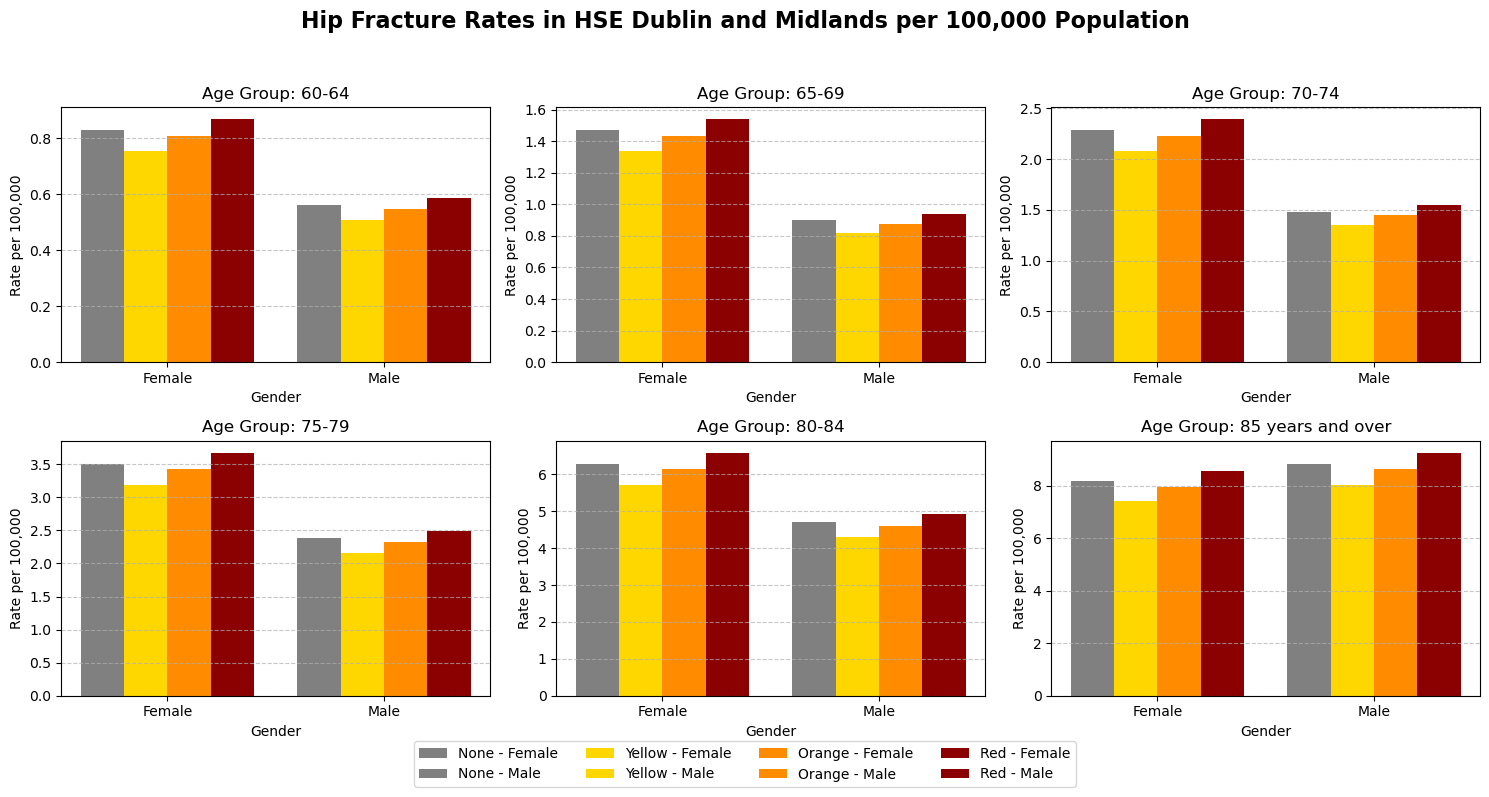

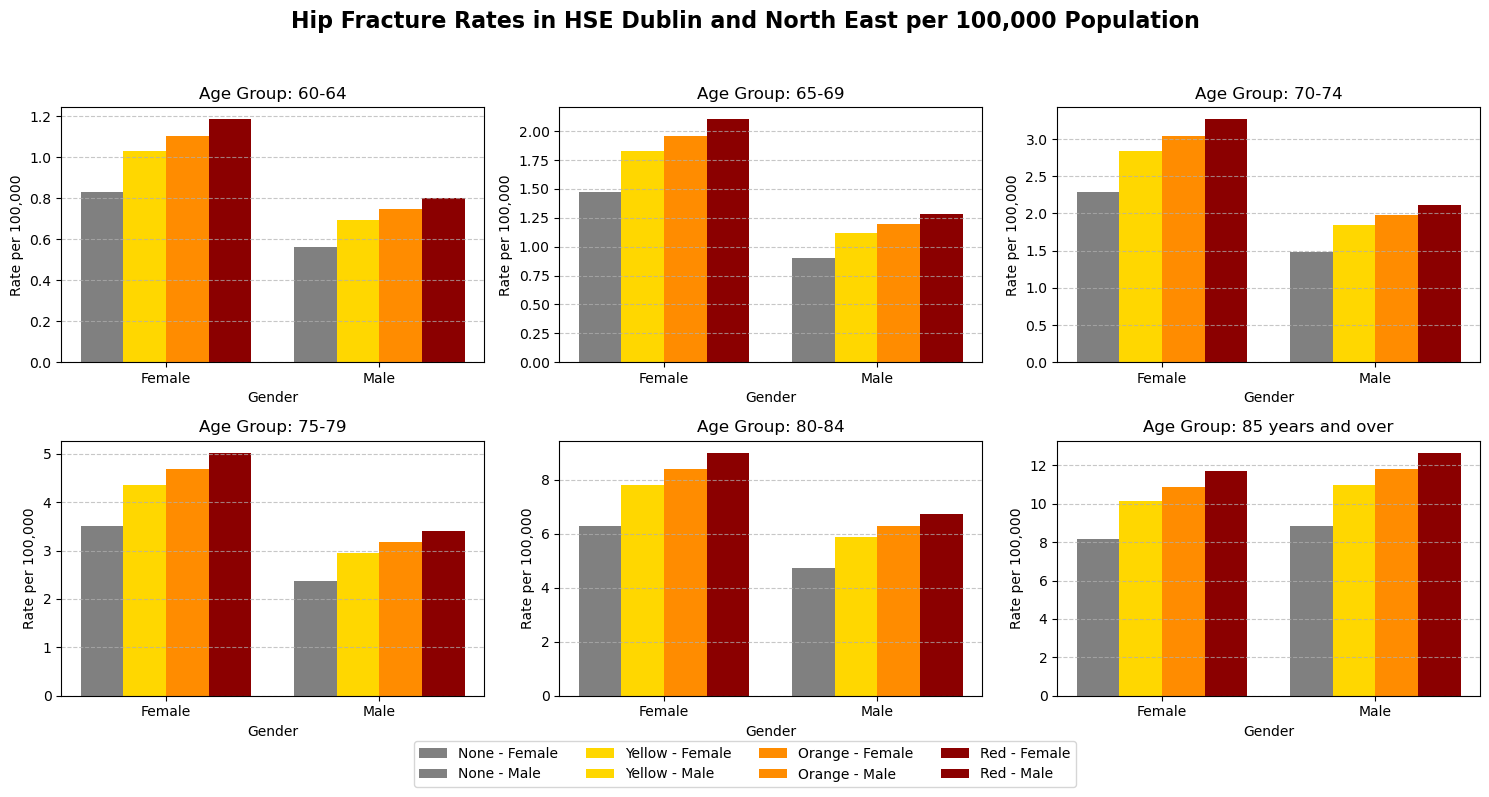

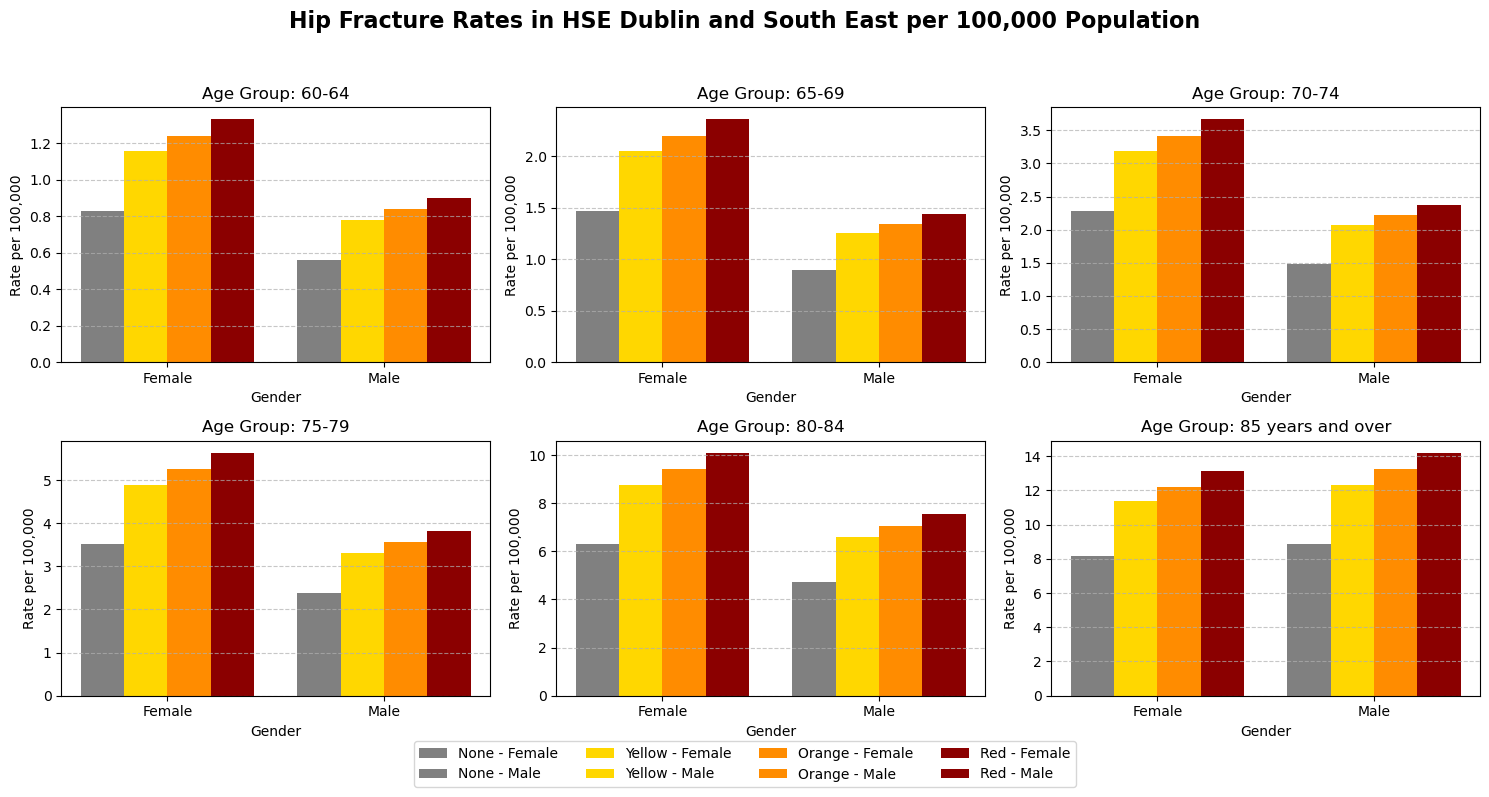

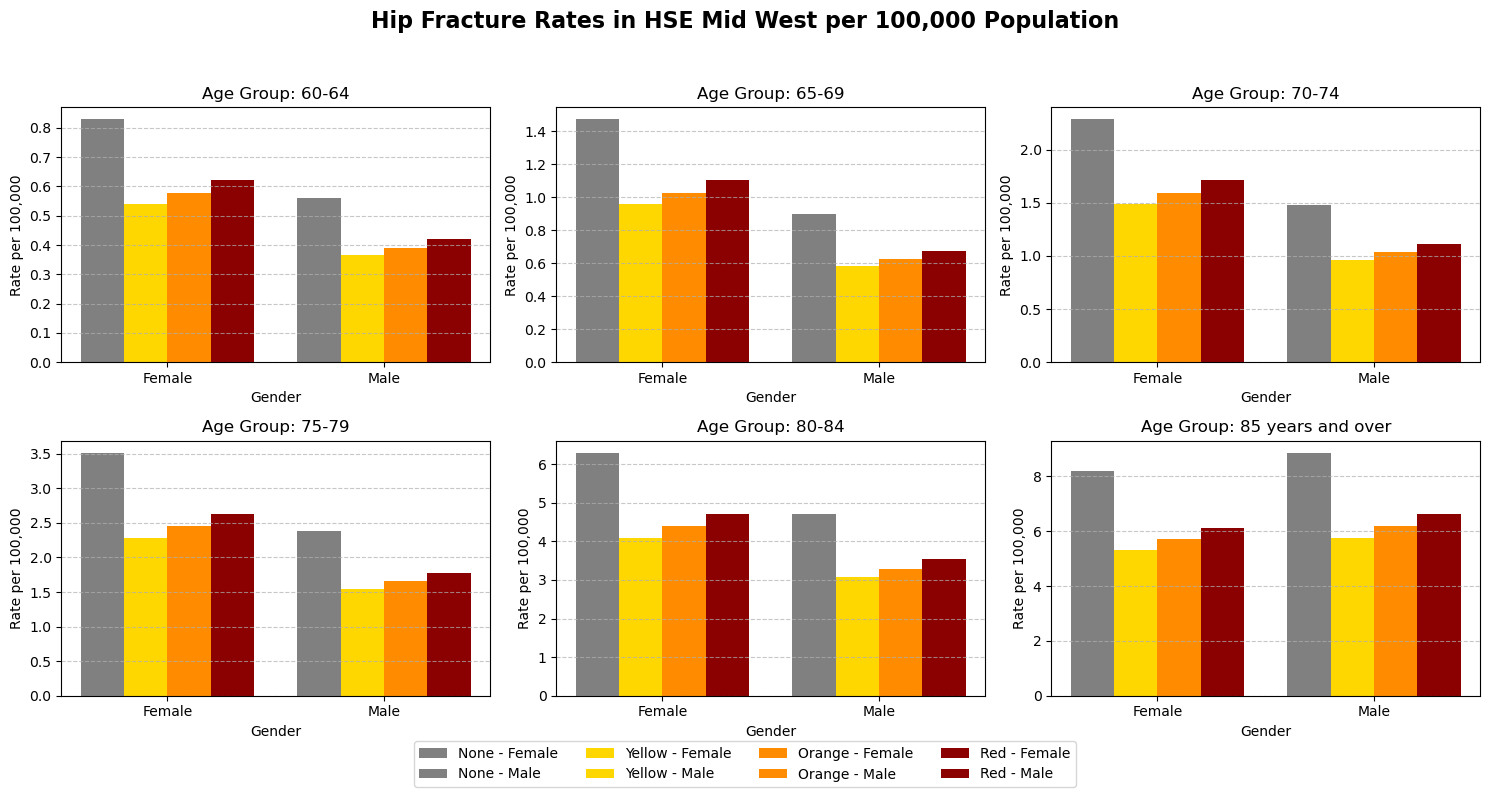

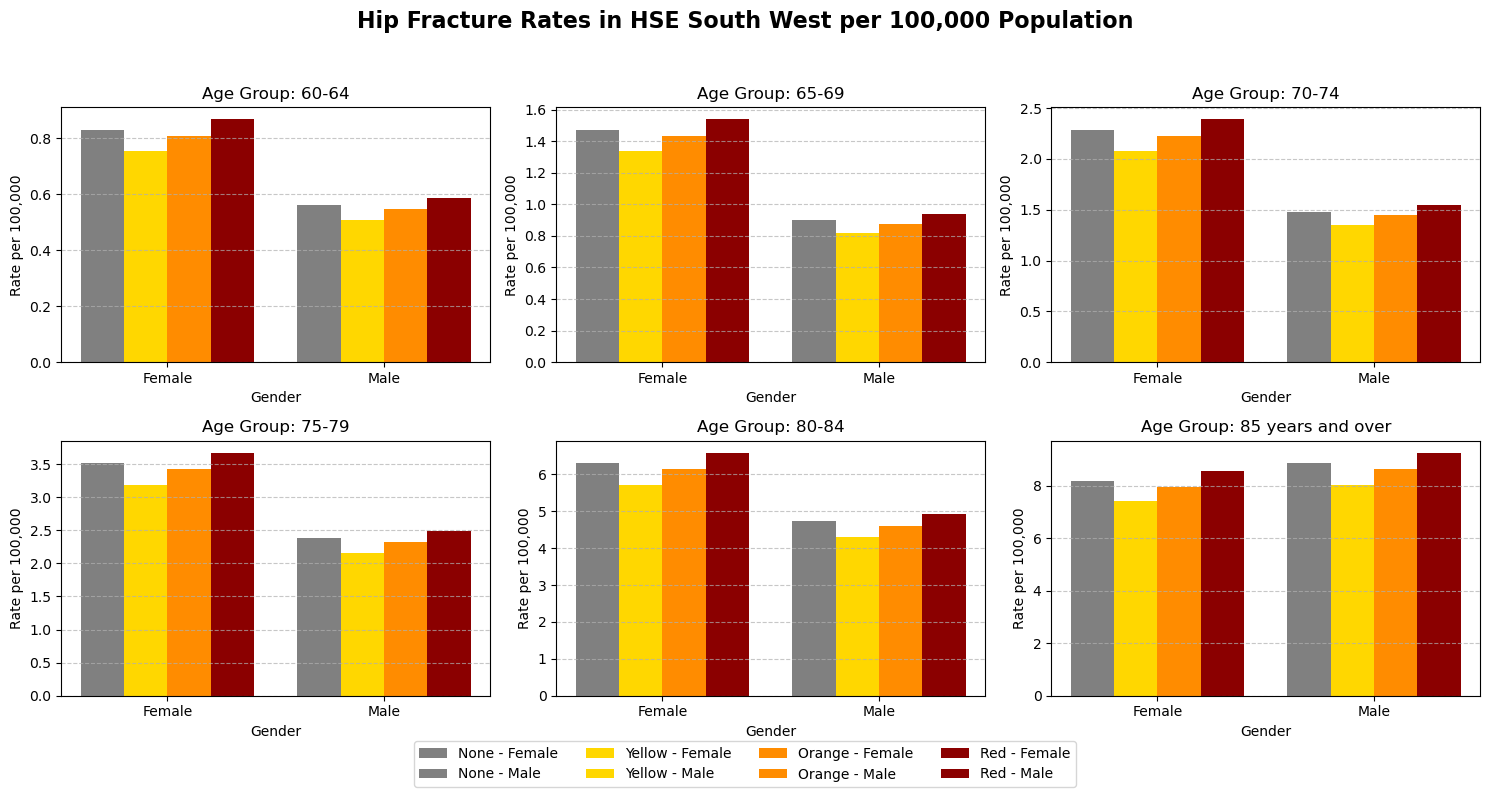

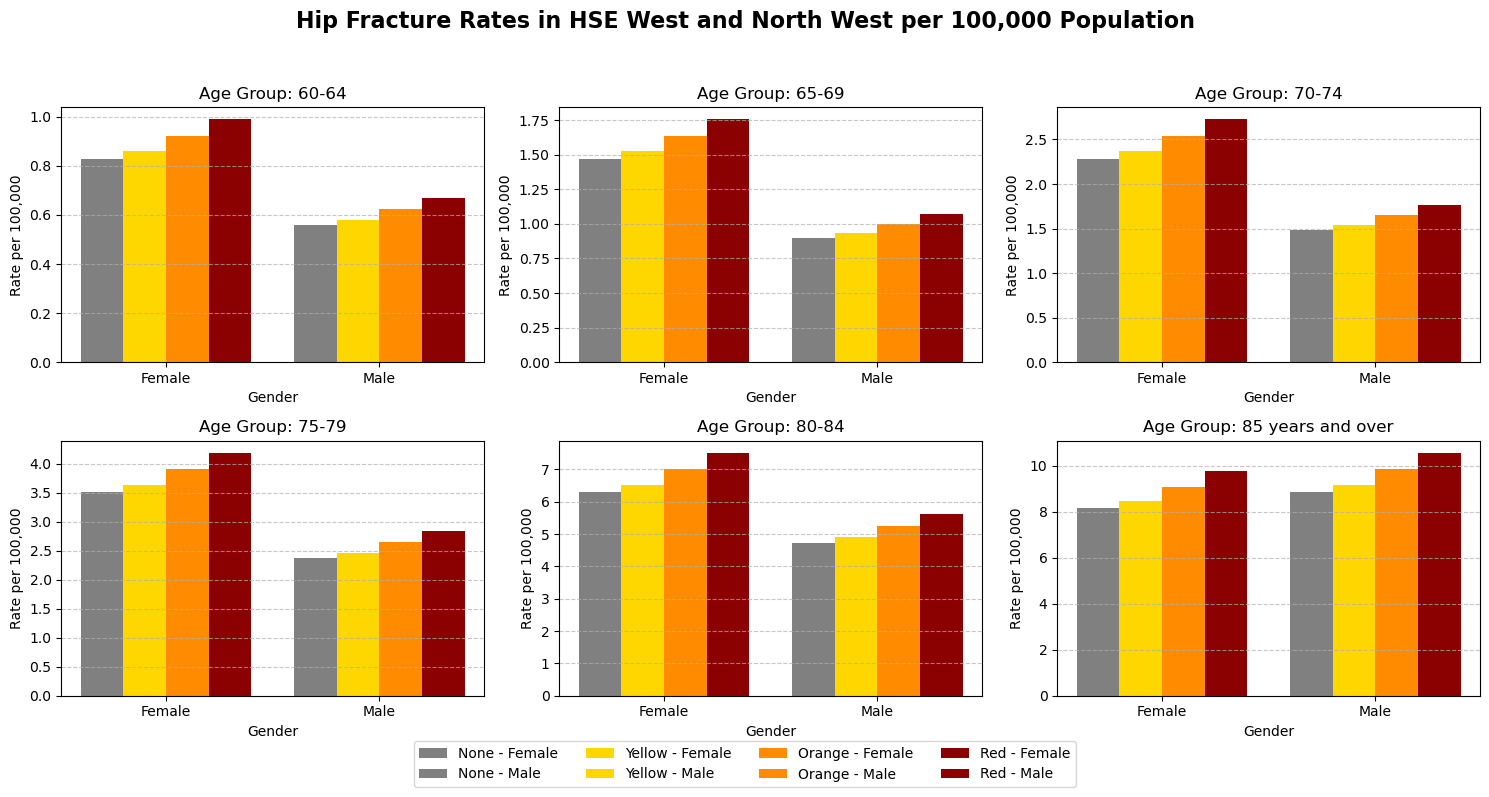

In [72]:
# Example usage:
rates = calculate_hip_fracture_rates(quasi_poisson_results, df_final_expanded, reference_population=100000)
plot_rates_by_region(rates)

#With optional variables:
#winter_rates = calculate_hip_fracture_rates(quasi_poisson_results, df_final_expanded, optional_vars={'is_winter': 1})
#plot_rates_by_region(winter_rates)

# summer_rates = calculate_hip_fracture_rates(model, df, optional_vars={'is_summer': 1})
# plot_rates_by_region(summer_rates)

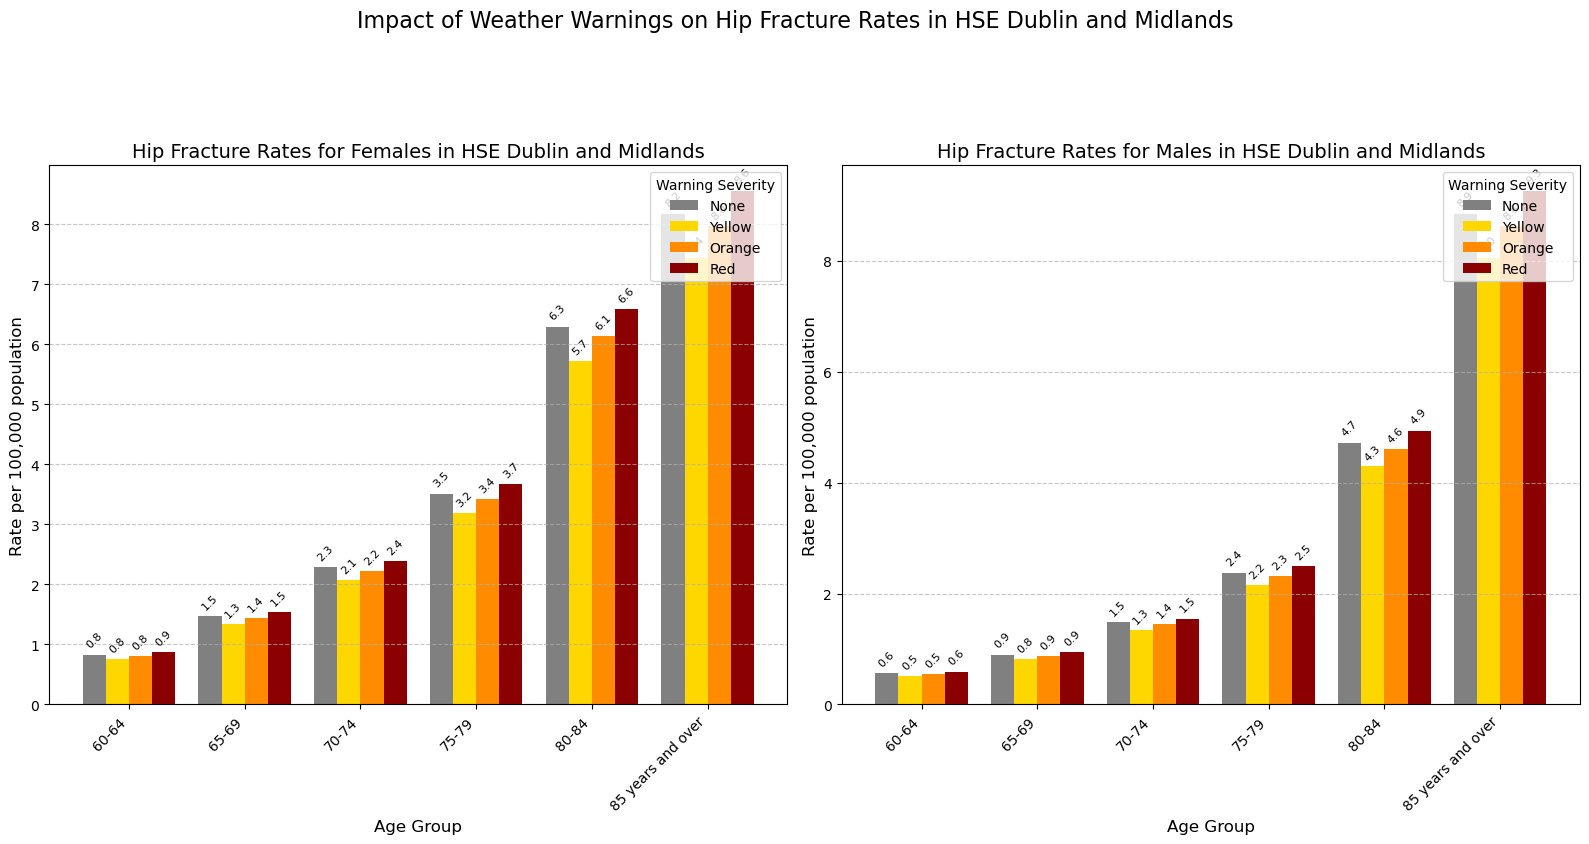

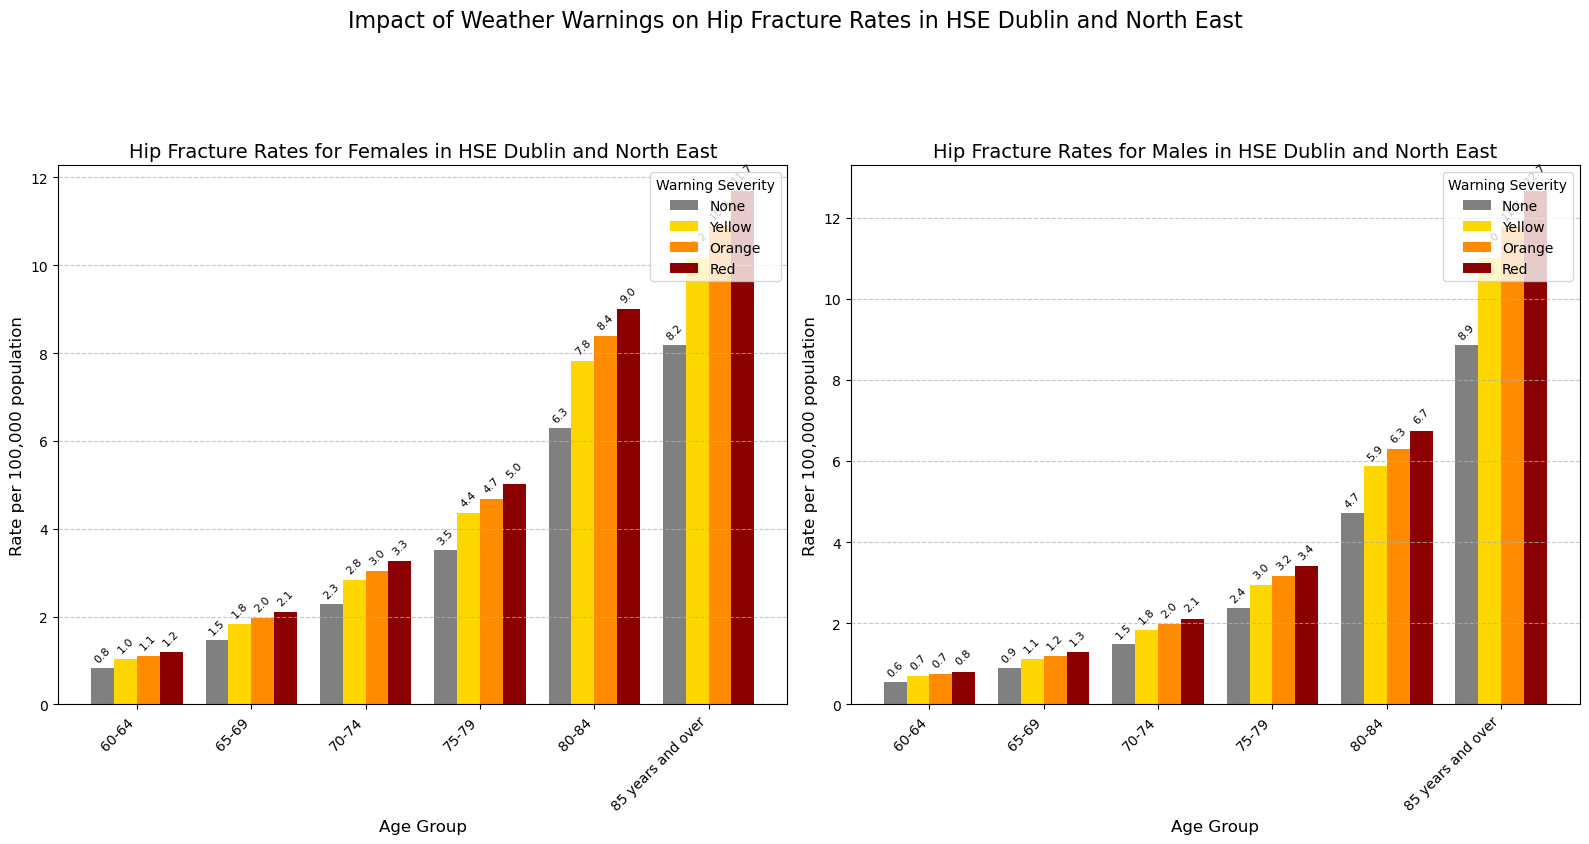

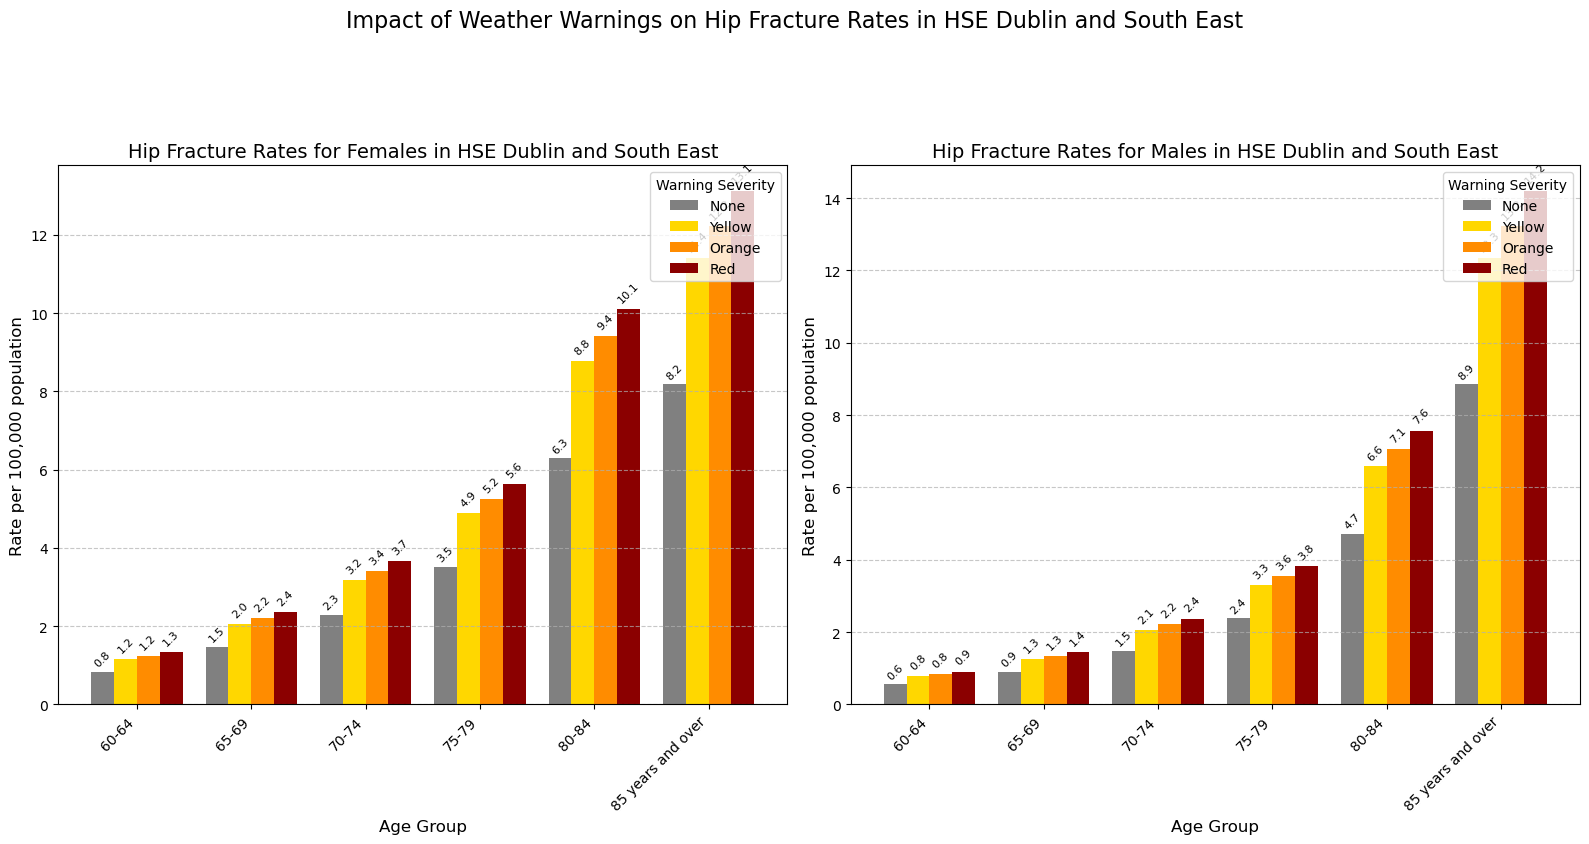

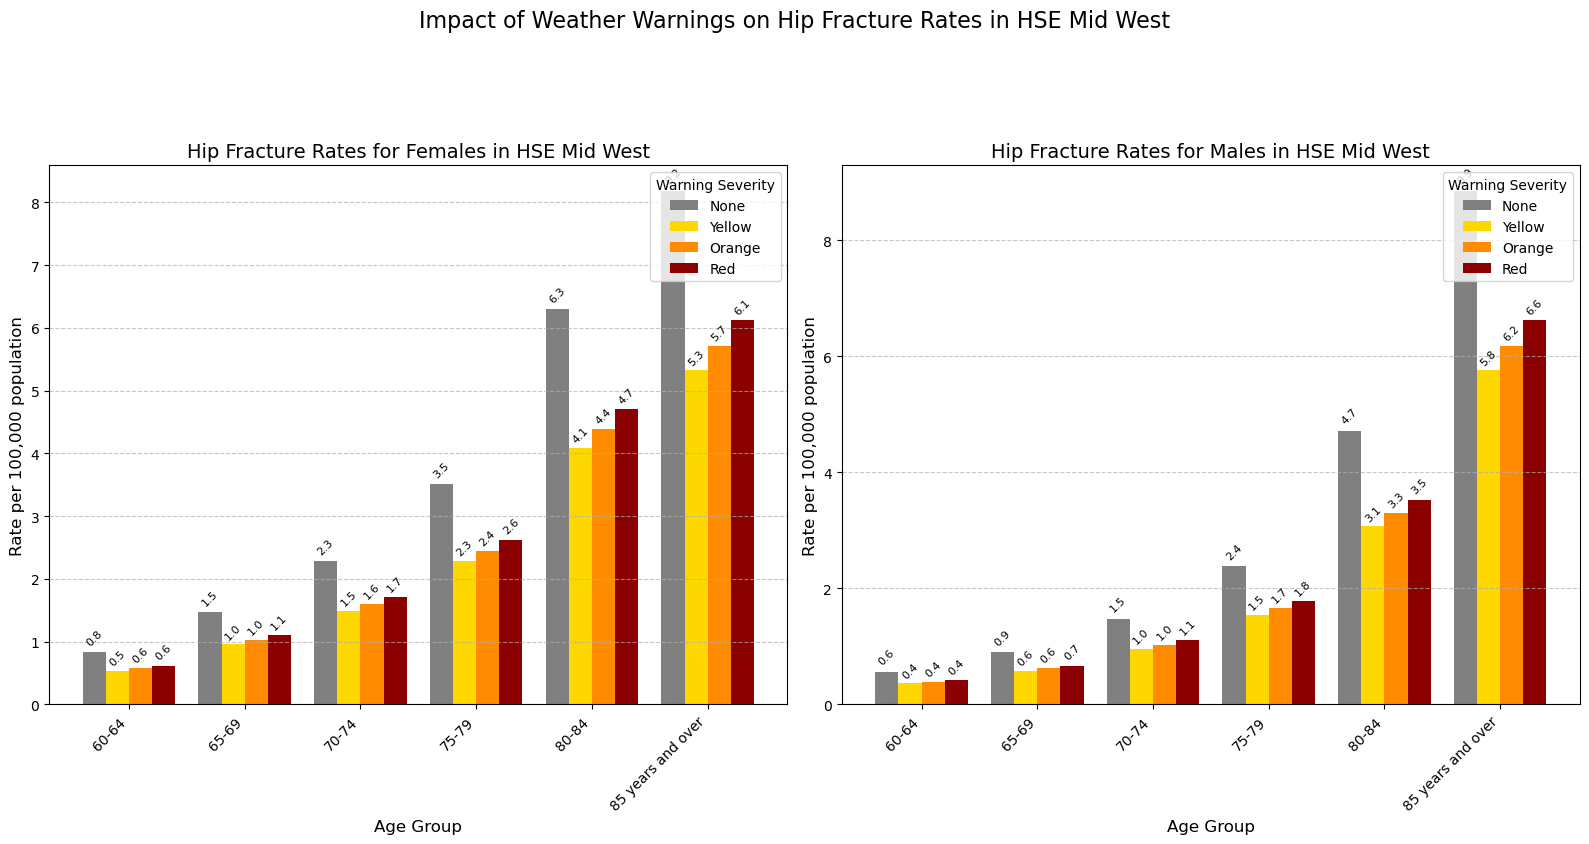

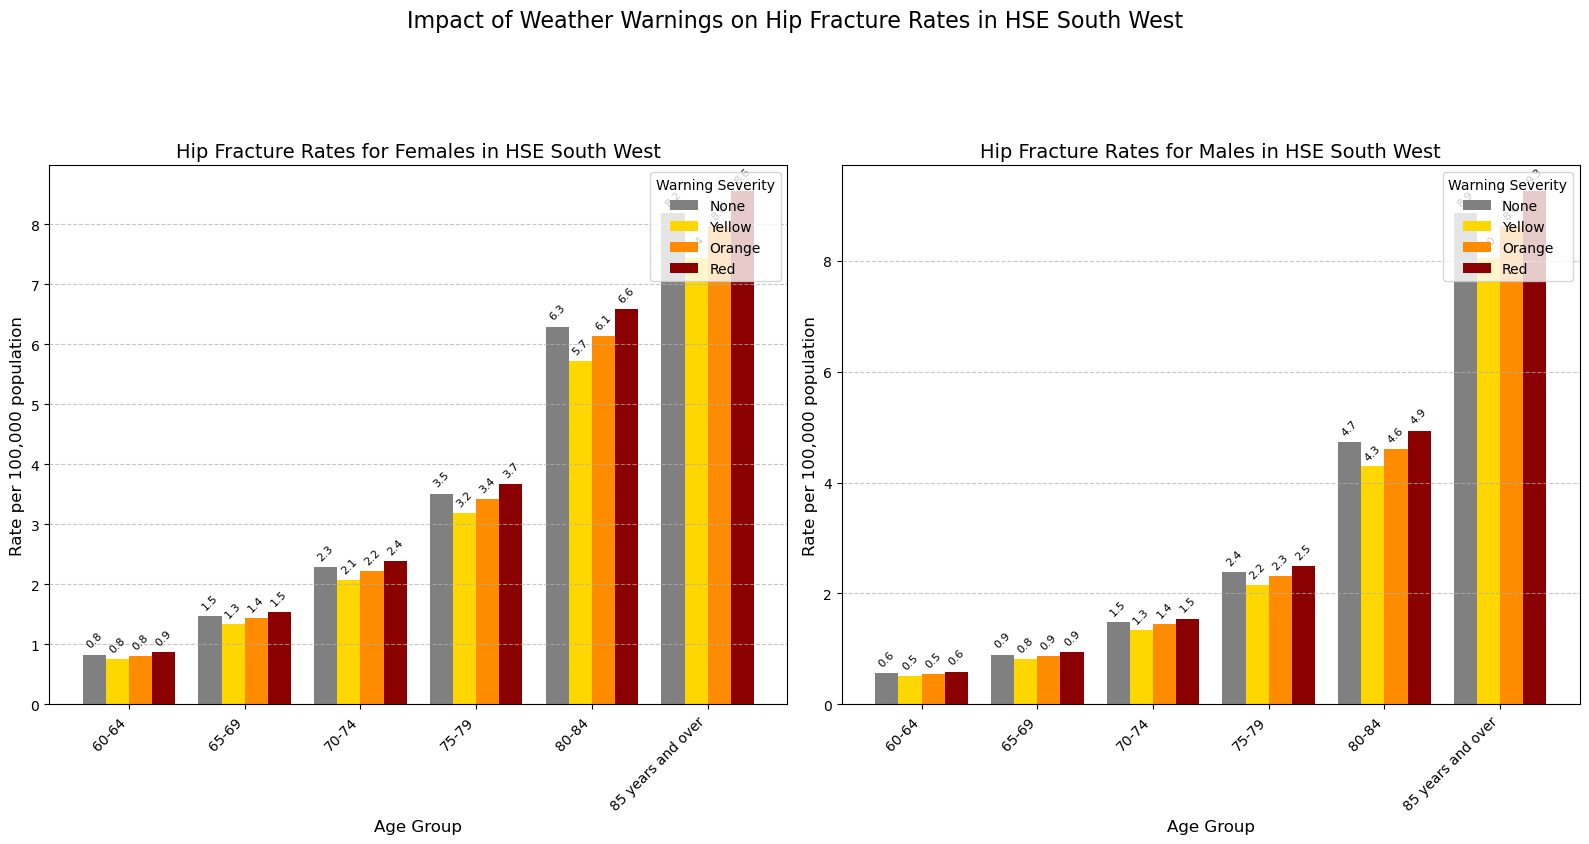

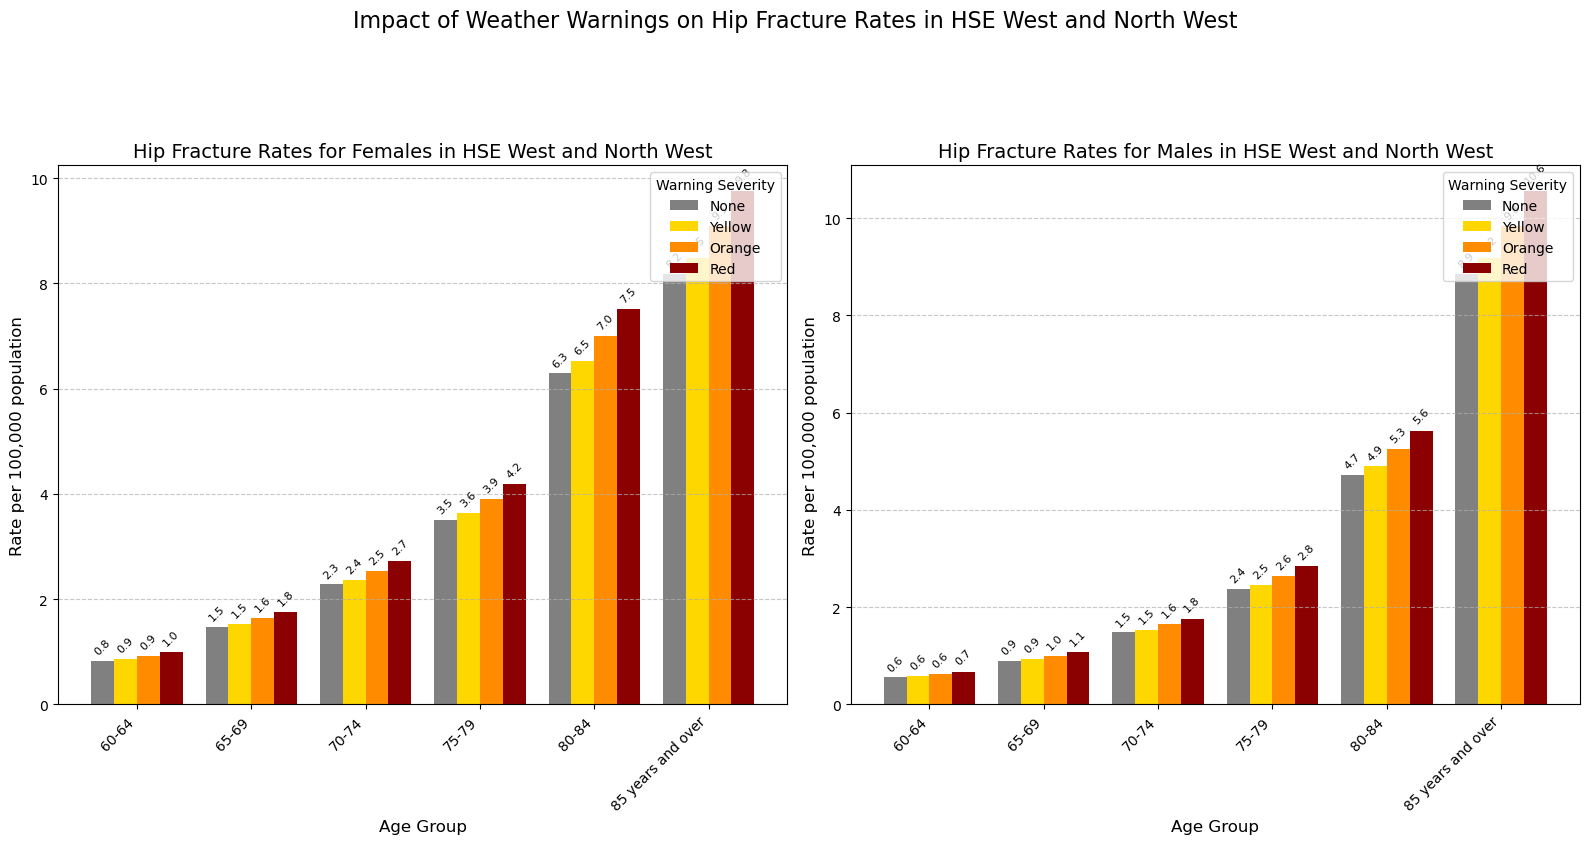

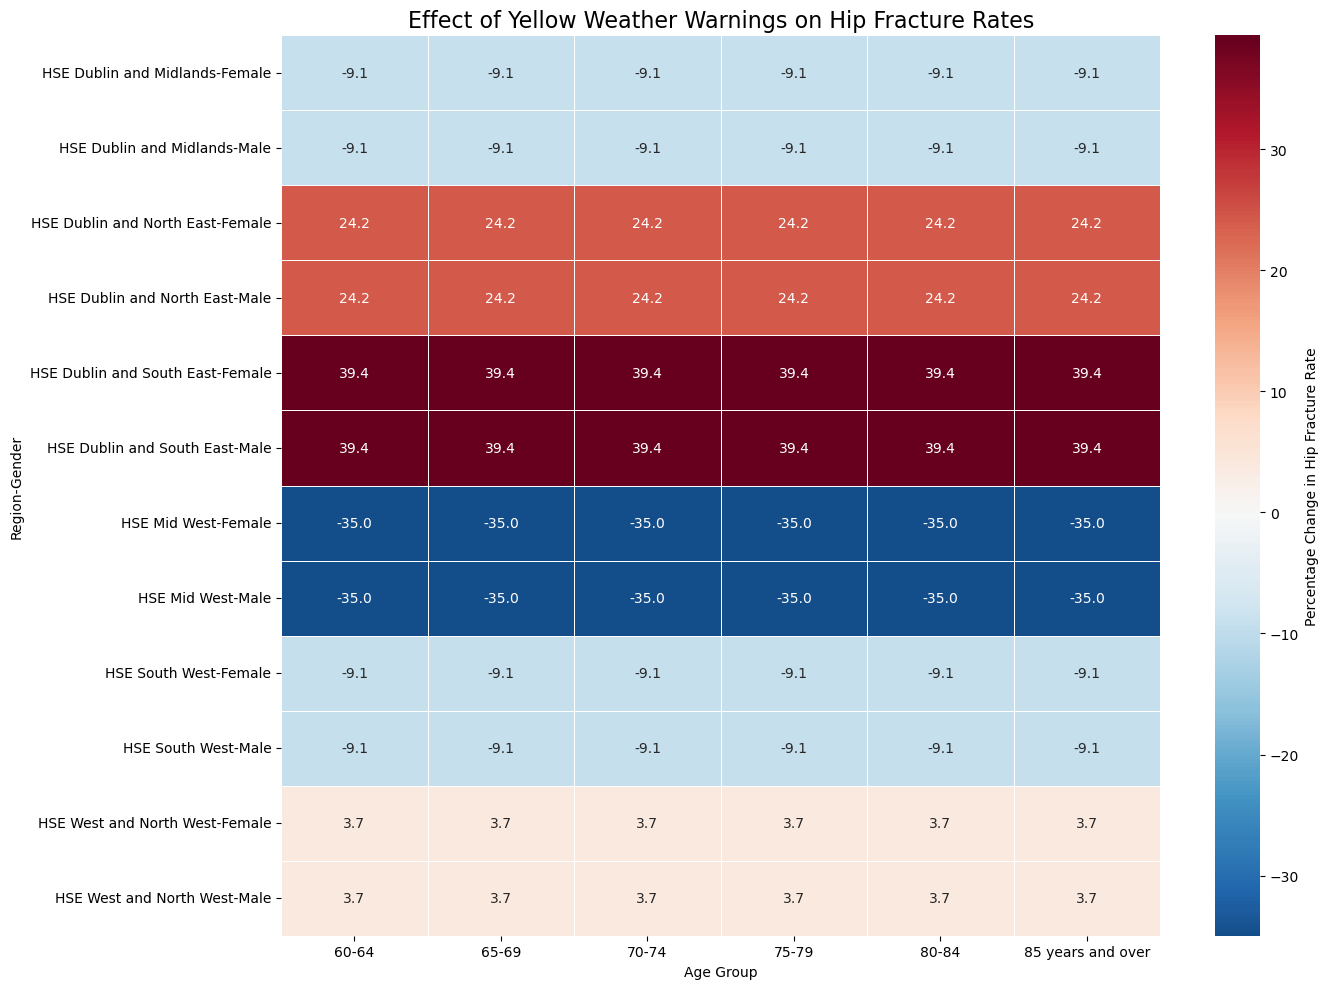

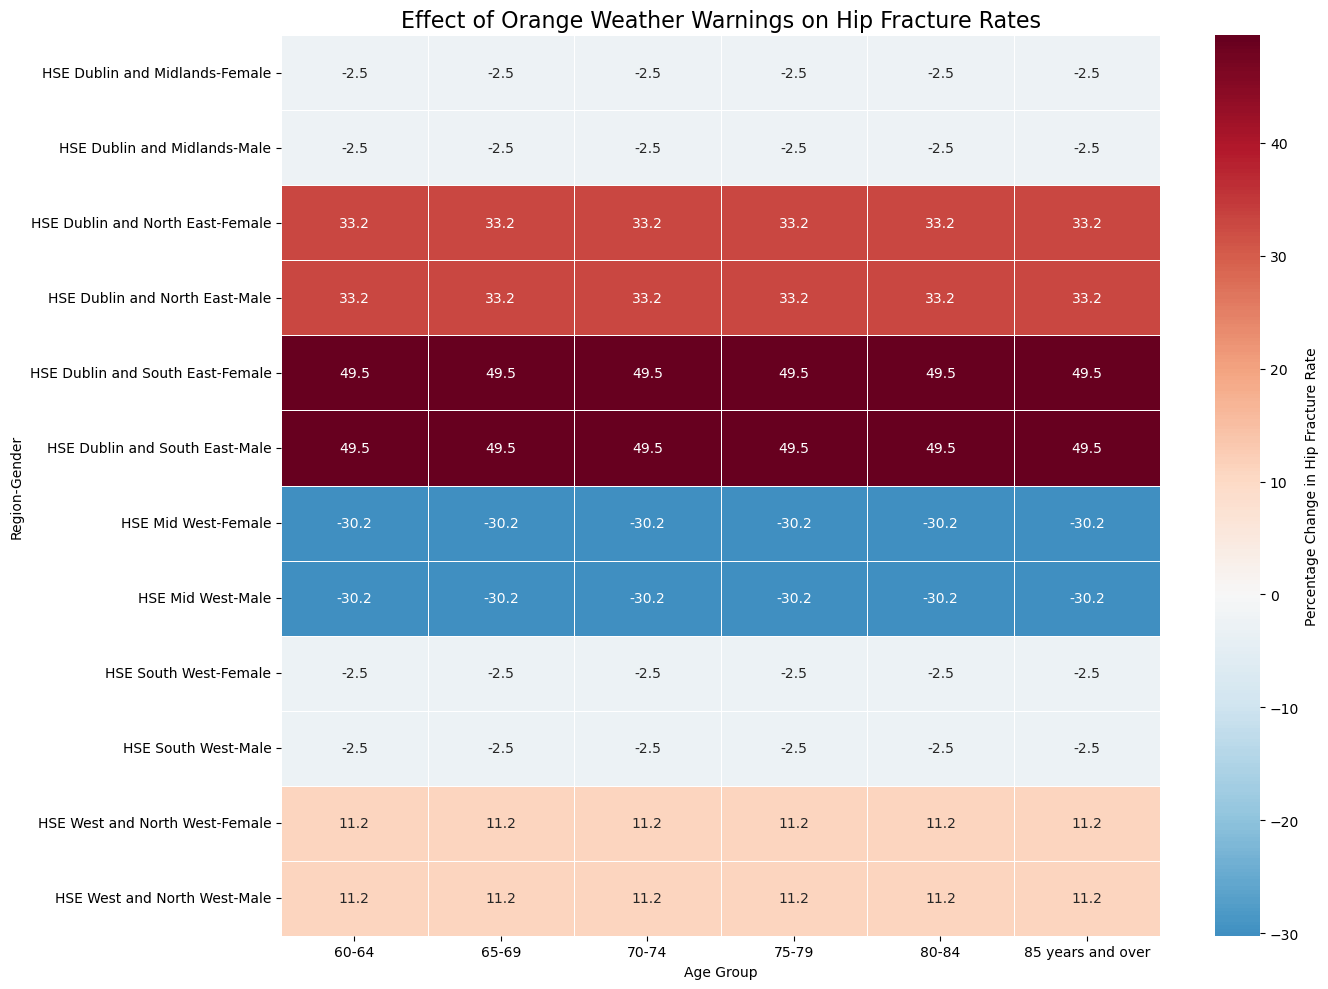

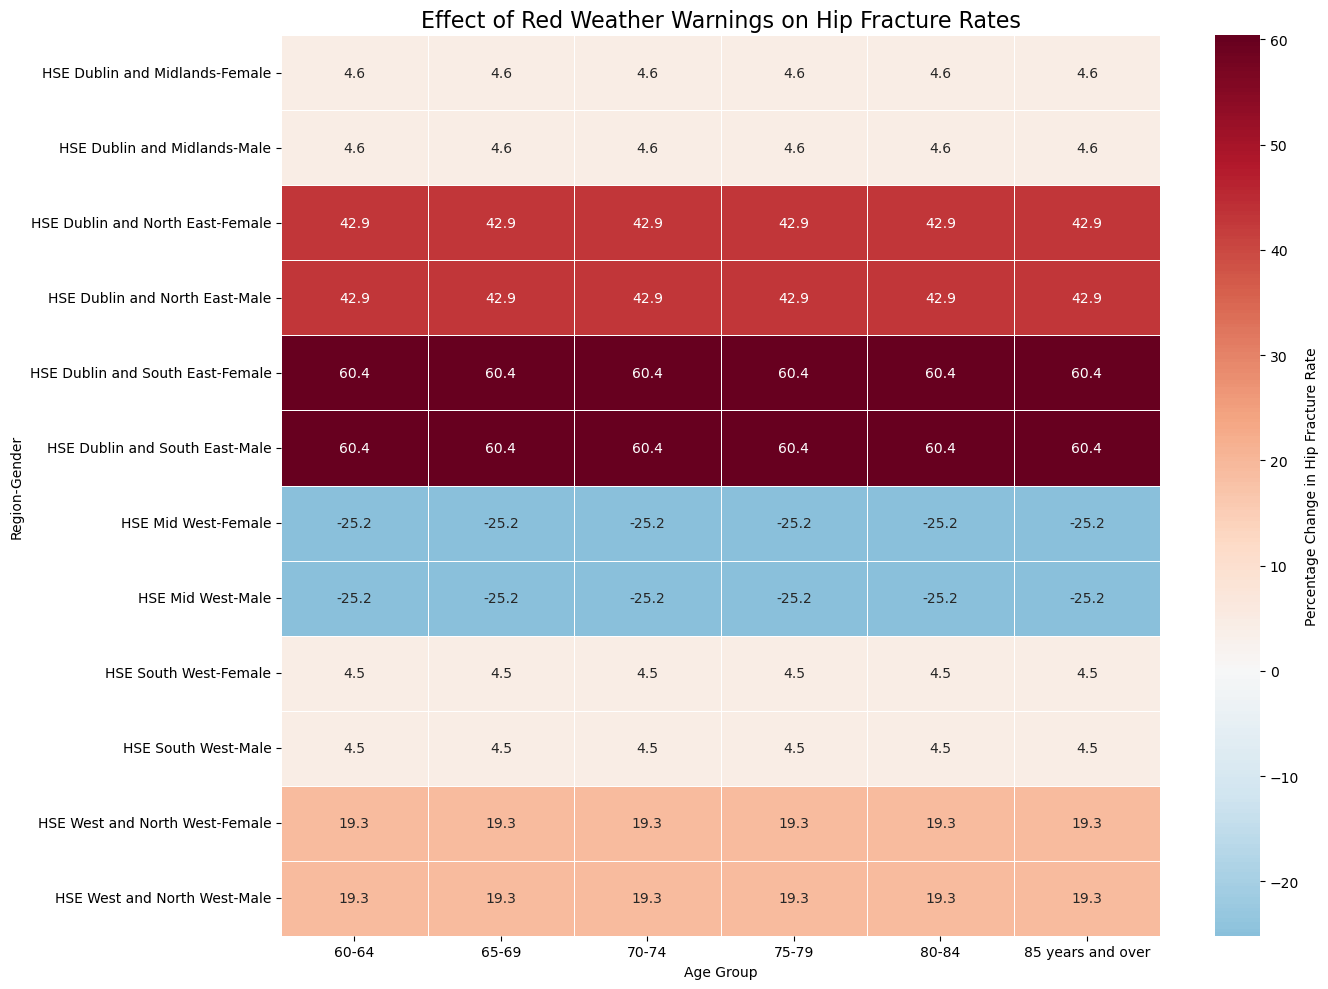

In [73]:
# Calculate rates
rates = calculate_hip_fracture_rates(quasi_poisson_results, df_final_expanded, reference_population=100000)

# Analyze effects
effects = analyze_scenario_effects(rates)

# Create visualizations
plot_regional_results(effects)
plot_summary_heatmap(effects)

In [74]:
# Imports
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt
import patsy
from statsmodels.discrete.discrete_model import GeneralizedPoisson
import seaborn as sns
from scipy import stats

# Define your formula
#formula = """
#hip_fracture_count ~ 
#weather_event +
#warning_severity_numeric +
#C(gender)*C(age_group) + 
#C(age_group) +  
#C(region):weather_event
#"""
formula = """
hip_fracture_count ~ 
C(weather_event, Treatment(reference=0)) +
C(warning_severity_numeric, Treatment(reference=0)) +
C(gender, Treatment(reference='Female'))*C(age_group) +
counties_in_region + 
C(region, Treatment(reference='HSE South West')):C(weather_event, Treatment(reference=0)) +
C(gender, Treatment(reference='Female')):C(weather_event, Treatment(reference=0))
"""
# Define the offset
offset = df_final_expanded["log_population"]

### 1. Fit Poisson Model (Baseline)
print("="*60)
print("FITTING POISSON MODEL (BASELINE)")
print("="*60)

poisson_model = smf.glm(
    formula=formula, 
    data=df_final_expanded, 
    family=sm.families.Poisson(), 
    offset=offset
)
poisson_results = poisson_model.fit()

# Dispersion estimate
dispersion = poisson_results.deviance / poisson_results.df_resid
print(f"\nPoisson Dispersion parameter: {dispersion:.4f}")

print("\nPoisson Model Summary:")
print(poisson_results.summary())

### 2. Fit Generalized Poisson Model (For Underdispersion)
print("\n" + "="*60)
print("FITTING GENERALIZED POISSON MODEL (FOR UNDERDISPERSION)")
print("="*60)

# Prepare design matrices
y, X = patsy.dmatrices(formula, data=df_final_expanded, return_type='dataframe')

# Convert y to 1D array
y_array = np.asarray(y).flatten()

try:
    gp_model = GeneralizedPoisson(endog=y_array, exog=X, offset=offset)
    gp_results = gp_model.fit(maxiter=1000, disp=False)
    
    print("\nGeneralized Poisson Model Summary:")
    print(gp_results.summary())
    gp_fitted = True
except Exception as e:
    print(f"\nGeneralized Poisson model failed: {e}")
    gp_fitted = False

### 3. Fit Negative Binomial Model (For Comparison)
print("\n" + "="*60)
print("FITTING NEGATIVE BINOMIAL MODEL (FOR COMPARISON)")
print("="*60)

try:
    nb_model = smf.negativebinomial(
        formula=formula, 
        data=df_final_expanded, 
        offset=offset
    )
    nb_results = nb_model.fit(disp=False)
    
    print("\nNegative Binomial Model Summary:")
    print(nb_results.summary())
    nb_fitted = True
except Exception as e:
    print(f"\nNegative Binomial model failed (expected for underdispersed data): {e}")
    nb_fitted = False

### 4. Functions to Calculate MSE and MAPE
def calculate_metrics(y_true, y_pred):
    """
    Calculate MSE and MAPE for model evaluation
    """
    # Ensure arrays are flattened
    y_true = np.asarray(y_true).flatten()
    y_pred = np.asarray(y_pred).flatten()
    
    # MSE
    mse = np.mean((y_true - y_pred)**2)
    
    # MAPE - handle zero values
    mask = y_true != 0
    if np.sum(mask) > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    # RMSE
    rmse = np.sqrt(mse)
    
    # MAE
    mae = np.mean(np.abs(y_true - y_pred))
    
    return mse, mape, rmse, mae

### 5. Get predictions and calculate metrics for each model
# Get actual values
y_actual = df_final_expanded['hip_fracture_count'].values

# Initialize lists to store results
models_list = []
predictions_list = []
metrics_dict = {}

# Poisson predictions
poisson_pred = poisson_results.predict()
poisson_mse, poisson_mape, poisson_rmse, poisson_mae = calculate_metrics(y_actual, poisson_pred)
models_list.append('Poisson')
predictions_list.append(poisson_pred)
metrics_dict['Poisson'] = (poisson_mse, poisson_mape, poisson_rmse, poisson_mae)

# Generalized Poisson predictions
if gp_fitted:
    gp_pred = gp_results.predict()
    gp_mse, gp_mape, gp_rmse, gp_mae = calculate_metrics(y_actual, gp_pred)
    models_list.append('Generalized Poisson')
    predictions_list.append(gp_pred)
    metrics_dict['Generalized Poisson'] = (gp_mse, gp_mape, gp_rmse, gp_mae)

# Negative Binomial predictions
if nb_fitted:
    nb_pred = nb_results.predict()
    nb_mse, nb_mape, nb_rmse, nb_mae = calculate_metrics(y_actual, nb_pred)
    models_list.append('Negative Binomial')
    predictions_list.append(nb_pred)
    metrics_dict['Negative Binomial'] = (nb_mse, nb_mape, nb_rmse, nb_mae)

# Print comparison
print("\n" + "="*60)
print("MODEL COMPARISON - PREDICTION METRICS")
print("="*60)
for model_name, (mse, mape, rmse, mae) in metrics_dict.items():
    print(f"\n{model_name} Model:")
    print(f"  MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}, MAPE: {mape:.2f}%")

# Check if predictions are different
print("\n" + "="*60)
print("CHECKING PREDICTION DIFFERENCES")
print("="*60)
if len(predictions_list) > 1:
    for i in range(len(predictions_list)-1):
        for j in range(i+1, len(predictions_list)):
            diff = np.mean(np.abs(predictions_list[i] - predictions_list[j]))
            max_diff = np.max(np.abs(predictions_list[i] - predictions_list[j]))
            print(f"\n{models_list[i]} vs {models_list[j]}:")
            print(f"  Mean absolute difference: {diff:.6f}")
            print(f"  Max absolute difference: {max_diff:.6f}")

### 6. Visualization Suite

# Create a figure with multiple subplots
n_models = len(models_list)
fig = plt.figure(figsize=(18, 12))

# Define colors for consistency
colors = ['steelblue', 'seagreen', 'coral'][:n_models]

# 1. Metrics Comparison Bar Plot - MSE and RMSE
ax1 = plt.subplot(2, 3, 1)
x = np.arange(len(models_list))
width = 0.35

mse_values = [metrics_dict[m][0] for m in models_list]
rmse_values = [metrics_dict[m][2] for m in models_list]

bars1 = ax1.bar(x - width/2, mse_values, width, label='MSE', color='steelblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, rmse_values, width, label='RMSE', color='darkblue', alpha=0.8)

ax1.set_ylabel('Error', fontsize=12)
ax1.set_title('MSE & RMSE Comparison (lower is better)', fontsize=14)
ax1.set_xticks(x)
ax1.set_xticklabels(models_list, rotation=15, ha='right')
ax1.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 2. MAPE and MAE Comparison
ax2 = plt.subplot(2, 3, 2)
mape_values = [metrics_dict[m][1] for m in models_list]
mae_values = [metrics_dict[m][3] for m in models_list]

bars3 = ax2.bar(x - width/2, mape_values, width, label='MAPE (%)', color='coral', alpha=0.8)
bars4 = ax2.bar(x + width/2, mae_values, width, label='MAE', color='orangered', alpha=0.8)

ax2.set_ylabel('Error', fontsize=12)
ax2.set_title('MAPE & MAE Comparison (lower is better)', fontsize=14)
ax2.set_xticks(x)
ax2.set_xticklabels(models_list, rotation=15, ha='right')
ax2.legend()

# Add value labels
for bar in bars3:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
for bar in bars4:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# 3. Combined Metrics Heatmap
ax3 = plt.subplot(2, 3, 3)
metrics_data = np.array([[metrics_dict[m][0], metrics_dict[m][2], metrics_dict[m][3], metrics_dict[m][1]] 
                         for m in models_list])

# Normalize each metric to 0-1 scale for visualization
metrics_normalized = metrics_data.copy()
for i in range(metrics_data.shape[1]):
    col = metrics_data[:, i]
    if col.max() != col.min():
        metrics_normalized[:, i] = (col - col.min()) / (col.max() - col.min())
    else:
        metrics_normalized[:, i] = 0

sns.heatmap(metrics_normalized, 
            xticklabels=['MSE', 'RMSE', 'MAE', 'MAPE'],
            yticklabels=models_list,
            annot=metrics_data, fmt='.3f', cmap='RdYlGn_r', ax=ax3,
            cbar_kws={'label': 'Normalized Score'})
ax3.set_title('Normalized Metrics Heatmap\n(darker = worse performance)', fontsize=14)

# 4-6. Actual vs Predicted Scatter Plots
for idx, (pred, model_name, color) in enumerate(zip(predictions_list[:3], models_list[:3], colors)):
    ax = plt.subplot(2, 3, 4 + idx)
    ax.scatter(y_actual, pred, alpha=0.5, s=30, color=color)
    
    # Add perfect prediction line
    max_val = max(y_actual.max(), pred.max())
    ax.plot([0, max_val], [0, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Add correlation coefficient
    corr = np.corrcoef(y_actual, pred)[0, 1]
    ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', 
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    ax.set_xlabel('Actual Count', fontsize=11)
    ax.set_ylabel('Predicted Count', fontsize=11)
    ax.set_title(f'{model_name}: Actual vs Predicted', fontsize=12)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional diagnostic plots
fig2, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1-3. Residual Plots
for idx, (pred, model_name, color) in enumerate(zip(predictions_list[:3], models_list[:3], colors)):
    if idx < len(axes[0]):
        ax = axes[0, idx]
        residuals = y_actual - pred
        
        ax.scatter(pred, residuals, alpha=0.5, s=30, color=color)
        ax.axhline(y=0, color='r', linestyle='--', lw=2)
        
        # Add residual statistics
        res_std = np.std(residuals)
        ax.axhline(y=2*res_std, color='orange', linestyle=':', alpha=0.7, label='±2 SD')
        ax.axhline(y=-2*res_std, color='orange', linestyle=':', alpha=0.7)
        
        ax.set_xlabel('Predicted Count', fontsize=11)
        ax.set_ylabel('Residuals', fontsize=11)
        ax.set_title(f'{model_name}: Residual Plot', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)

# 4. Q-Q plot for residuals
ax = axes[1, 0]
for idx, (pred, model_name, color) in enumerate(zip(predictions_list, models_list, colors)):
    residuals = y_actual - pred
    stats.probplot(residuals, dist="norm", plot=None)
    theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(residuals)))
    theoretical_quantiles.sort()
    residuals_sorted = np.sort(residuals)
    ax.plot(theoretical_quantiles, residuals_sorted, 'o', alpha=0.6, label=model_name, 
            color=color, markersize=4)

ax.plot([-3, 3], [-3*np.std(y_actual), 3*np.std(y_actual)], 'k--', lw=2, label='Reference line')
ax.set_xlabel('Theoretical Quantiles')
ax.set_ylabel('Sample Quantiles')
ax.set_title('Q-Q Plot: Residual Normality Check')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Distribution of predictions
ax = axes[1, 1]
ax.hist(y_actual, bins=30, alpha=0.7, label='Actual', color='black', density=True)
for idx, (pred, model_name, color) in enumerate(zip(predictions_list, models_list, colors)):
    ax.hist(pred, bins=30, alpha=0.5, label=model_name, color=color, density=True)
ax.set_xlabel('Count')
ax.set_ylabel('Density')
ax.set_title('Distribution of Actual vs Predicted Counts')
ax.legend()

# 6. Model performance by prediction magnitude
ax = axes[1, 2]
n_bins = 10
for idx, (pred, model_name, color) in enumerate(zip(predictions_list, models_list, colors)):
    # Create bins based on actual values
    bin_edges = np.percentile(y_actual[y_actual > 0], np.linspace(0, 100, n_bins + 1))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    mape_by_bin = []
    for i in range(n_bins):
        mask = (y_actual >= bin_edges[i]) & (y_actual < bin_edges[i+1]) & (y_actual > 0)
        if np.sum(mask) > 0:
            bin_mape = np.mean(np.abs((y_actual[mask] - pred[mask]) / y_actual[mask])) * 100
            mape_by_bin.append(bin_mape)
        else:
            mape_by_bin.append(np.nan)
    
    ax.plot(bin_centers, mape_by_bin, 'o-', label=model_name, color=color, 
            linewidth=2, markersize=8)

ax.set_xlabel('Actual Count (bin center)')
ax.set_ylabel('MAPE (%)')
ax.set_title('MAPE by Actual Count Magnitude')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics table
print("\n" + "="*60)
print("DETAILED MODEL DIAGNOSTICS")
print("="*60)

for pred, model_name in zip(predictions_list, models_list):
    residuals = y_actual - pred
    print(f"\n{model_name} Model:")
    print(f"  Mean Residual: {np.mean(residuals):.4f}")
    print(f"  Std Dev of Residuals: {np.std(residuals):.4f}")
    print(f"  Min/Max Residual: {np.min(residuals):.4f} / {np.max(residuals):.4f}")
    print(f"  % Predictions within ±1 of actual: {np.mean(np.abs(residuals) <= 1)*100:.1f}%")
    print(f"  % Predictions within ±2 of actual: {np.mean(np.abs(residuals) <= 2)*100:.1f}%")
    
# Dispersion analysis
print("\n" + "="*60)
print("DISPERSION ANALYSIS")
print("="*60)
print(f"Poisson model dispersion parameter: {dispersion:.4f}")
if dispersion < 0.8:
    print("Strong evidence of underdispersion - Generalized Poisson should perform better than standard Poisson")
elif dispersion < 1.0:
    print("Moderate underdispersion detected - Generalized Poisson may improve model fit")
elif dispersion > 1.2:
    print("Overdispersion detected - Negative Binomial might be appropriate")
else:
    print("Little evidence of over/underdispersion - Poisson model may be adequate")

# Model selection recommendation
print("\n" + "="*60)
print("MODEL SELECTION RECOMMENDATION")
print("="*60)

best_model = min(metrics_dict.items(), key=lambda x: x[1][0])[0]  # Based on MSE
print(f"\nBased on MSE, the best model is: {best_model}")

best_model_mape = min(metrics_dict.items(), key=lambda x: x[1][1])[0]  # Based on MAPE
print(f"Based on MAPE, the best model is: {best_model_mape}")

if gp_fitted:
    # Extract dispersion parameter from Generalized Poisson
    try:
        gp_alpha = gp_results.params[-1]  # Last parameter is usually dispersion
        print(f"\nGeneralized Poisson dispersion parameter (alpha): {gp_alpha:.4f}")
        if gp_alpha < 0:
            print("Negative alpha confirms underdispersion in the data")
        elif gp_alpha > 0:
            print("Positive alpha indicates overdispersion")
        else:
            print("Alpha ≈ 0 indicates equidispersion (similar to Poisson)")
    except:
        pass



FITTING POISSON MODEL (BASELINE)


PatsyError: Error evaluating factor: NameError: name 'counties_in_region' is not defined
    hip_fracture_count ~  C(weather_event, Treatment(reference=0)) + C(warning_severity_numeric, Treatment(reference=0)) + C(gender, Treatment(reference='Female'))*C(age_group) + counties_in_region +  C(region, Treatment(reference='HSE South West')):C(weather_event, Treatment(reference=0)) + C(gender, Treatment(reference='Female')):C(weather_event, Treatment(reference=0))
                                                                                                                                                                                   ^^^^^^^^^^^^^^^^^^

In [ ]:
# Refit Poisson model with robust standard errors
poisson_robust_results = poisson_model.fit(cov_type='HC0')

# Print the summary with robust SEs
print("\nPoisson Model with Robust Standard Errors:")
print(poisson_robust_results.summary())Skip to main panel
/
/processed_data/analysed_data/
